# Prediction of 1 MeV Electron Fluxes in Low Earth Orbit Using NOAA-15 and Solar Wind Data
## Step 1

In [2]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Téléchargement des fichiers

In [3]:
def download_ncei_noaa15_nc(year_start=2020, year_end=2024):
    import os
    import re
    import requests

    BASE = "https://www.ncei.noaa.gov/data/poes-metop-space-environment-monitor/access/l1b/v01r00"
    OUT_ROOT = "NCEI_NOAA15"
    os.makedirs(OUT_ROOT, exist_ok=True)

    # regex simple : on garde tout ce qui finit par .nc (peu importe le préfixe exact)
    rx_nc = re.compile(r'\.nc$', re.IGNORECASE)

    # petite session requests pour réutiliser la connexion + UA propre
    session = requests.Session()
    session.headers.update({
        "User-Agent": "python-requests (NOAA-NCEI downloader for personal research)"
    })

    total_downloaded = 0
    for year in range(int(year_start), int(year_end) + 1):
        year_url = f"{BASE}/{year}/noaa15/"
        print(f"\n====================")
        print(f"Année {year}")
        print(f"Listing : {year_url}")

        # lister le répertoire année/noaa15
        try:
            r = session.get(year_url, timeout=60)
            r.raise_for_status()
        except Exception as e:
            print(f"❌ Impossible de lister {year_url} : {e}")
            continue

        # extraire tous les href de la page (HTML index simple)
        hrefs = re.findall(r'href="([^"]+)"', r.text)

        # ne garder que les fichiers .nc (pas les sous-dossiers, pas .md5, etc.)
        files = [h for h in hrefs if rx_nc.search(h)]
        # nettoyer le nom (si lien relatif type "./file.nc" ou "?params")
        files = [os.path.basename(h.split('?')[0]) for h in files]
        # enlever les doublons et trier
        files = sorted(set(files))

        if not files:
            print("⚠️  Aucun fichier .nc trouvé pour cette année/noaa15.")
            continue

        print(f"✅ {len(files)} fichier(s) .nc trouvé(s) pour {year} / noaa15")

        year_out = os.path.join(OUT_ROOT, str(year))
        os.makedirs(year_out, exist_ok=True)

        # télécharger chaque fichier
        downloaded_this_year = 0
        for i, fname in enumerate(files, 1):
            url_file = f"{year_url}{fname}"
            out_path = os.path.join(year_out, fname)

            if os.path.exists(out_path):
                print(f"[{year}] ({i}/{len(files)}) déjà présent, on saute : {fname}")
                continue

            print(f"[{year}] ({i}/{len(files)}) ↓ Téléchargement : {url_file}")
            try:
                rf = session.get(url_file, timeout=180)
                rf.raise_for_status()
                with open(out_path, "wb") as f:
                    f.write(rf.content)
                size = len(rf.content)
                print(f"[{year}]     ✅ Sauvé : {out_path} — {size:,} octets")
                downloaded_this_year += 1
                total_downloaded += 1
            except Exception as e:
                print(f"[{year}]     ❌ Échec : {fname} — {e}")

        print(f"[{year}] Résumé : {downloaded_this_year} nouveau(x) fichier(s) téléchargé(s).")

    print(f"\n🏁 Terminé. Total nouveaux fichiers téléchargés : {total_downloaded}")


In [4]:
# On veut les fichiers de 2020 à 2024
#download_ncei_noaa15_nc(2020, 2024)

In [5]:
# Afficher le flux d'électrons à partir d'un fichier téléchargé et une carte du monde
#import cartopy.crs as ccrs  # Pour les projections de carte

    # --- 5. Création du graphique pour flux d'electron ---
    
"""plt.figure(figsize=(18, 9)) 
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Fond de carte satellite
    ax.stock_img()
    ax.coastlines(color='yellow', linewidth=0.7)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Limites de couleur (ignorant les NaN)
    vmin = np.nanpercentile(data_to_plot, 5)
    vmax = np.nanpercentile(data_to_plot, 95)
    
    # Si les données sont en log (très courant pour les flux),
    # on peut utiliser une échelle log.
    # Pour l'instant, restons en linéaire.
    
    print("Création du graphique...")

    # --- Le TRACÉ ---
    sc = ax.scatter(
        lon, 
        lat, 
        c=data_to_plot,
        s=1,               # Taille du point
        cmap='jet',        # Palette de couleurs
        vmin=vmin,         
        vmax=vmax,         
        transform=ccrs.Geodetic() 
    )

    # Ajouter une barre de couleur
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
    cbar.set_label(f'{data_long_name}\n({data_units})')

    # Ajouter un titre
    plt.title(f'Données NOAA-15 ({VAR_DATA}) - {file_name}', fontsize=16)

    # Afficher le graphique
    plt.show()"""


'plt.figure(figsize=(18, 9)) \n    ax = plt.axes(projection=ccrs.PlateCarree())\n    \n    # Fond de carte satellite\n    ax.stock_img()\n    ax.coastlines(color=\'yellow\', linewidth=0.7)\n    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)\n\n    # Limites de couleur (ignorant les NaN)\n    vmin = np.nanpercentile(data_to_plot, 5)\n    vmax = np.nanpercentile(data_to_plot, 95)\n    \n    # Si les données sont en log (très courant pour les flux),\n    # on peut utiliser une échelle log.\n    # Pour l\'instant, restons en linéaire.\n    \n    print("Création du graphique...")\n\n    # --- Le TRACÉ ---\n    sc = ax.scatter(\n        lon, \n        lat, \n        c=data_to_plot,\n        s=1,               # Taille du point\n        cmap=\'jet\',        # Palette de couleurs\n        vmin=vmin,         \n        vmax=vmax,         \n        transform=ccrs.Geodetic() \n    )\n\n    # Ajouter une barre de couleur\n    cbar = plt.colorbar(sc, ax=ax, orientation=\'ve

Importer le fichier et afficher les variables

In [6]:
# 1. Ouvrir le fichier NetC dataset en lecture
file_path = r"C:\Users\gabri\OneDrive\Documents\IPSA\AERO5\Analyse_donnees_spatiales\PROJET\NCEI_NOAA15\2020\poes_n15_20200101_proc.nc"
dataset = Dataset(file_path, mode="r")

# print(dataset)

# 2. Afficher les dimensions
"""print("\n--- Dimensions ---")
for dim_name, dim in dataset.dimensions.items():
    print(f"{dim_name}: taille = {len(dim)}")

# 3. Afficher les variables disponibles
print("\n--- Variables ---")
for var_name, var in dataset.variables.items():
    print(f"{var_name}: shape = {var.shape}, dtype = {var.dtype}")

# 4. Afficher les attributs globaux (métadonnées du fichier)
print("\n--- Attributs globaux ---")
for attr_name in dataset.ncattrs():
    print(f"{attr_name}: {getattr(dataset, attr_name)}")"""

#  5. Exemple : lire les unités d'une variable (ex. "TIME" ou "L_VALUE")
print("\n--- Unités des variables ---")
for var_name, var in dataset.variables.items():
    units = getattr(var, "units", "No units")
    print(f"{var_name}: {units}")

#  6. Exemple de lecture de données
if "TIME" in dataset.variables:
    time_values = dataset.variables["TIME"][:]
    print("\nExemple de variable TIME:", time_values[:10])  # premiers points




--- Unités des variables ---
time: time
year: year
day: day
msec: millisec
satID: ID
sat_direction: 
alt: km
lat: degrees
lon: degrees
mep_pro_tel0_flux_p1: #/cm2-s-str-keV
mep_pro_tel0_flux_p2: #/cm2-s-str-keV
mep_pro_tel0_flux_p3: #/cm2-s-str-keV
mep_pro_tel0_flux_p4: #/cm2-s-str-keV
mep_pro_tel0_flux_p5: #/cm2-s-str-keV
mep_pro_tel0_flux_p6: #/cm2-s-str
mep_pro_tel0_flux_p1_err: #/cm2-s-str-keV
mep_pro_tel0_flux_p2_err: #/cm2-s-str-keV
mep_pro_tel0_flux_p3_err: #/cm2-s-str-keV
mep_pro_tel0_flux_p4_err: #/cm2-s-str-keV
mep_pro_tel0_flux_p5_err: #/cm2-s-str-keV
mep_pro_tel0_flux_p6_err: #/cm2-s-str
mep_pro_tel90_flux_p1: #/cm2-s-str-keV
mep_pro_tel90_flux_p2: #/cm2-s-str-keV
mep_pro_tel90_flux_p3: #/cm2-s-str-keV
mep_pro_tel90_flux_p4: #/cm2-s-str-keV
mep_pro_tel90_flux_p5: #/cm2-s-str-keV
mep_pro_tel90_flux_p6: #/cm2-s-str
mep_pro_tel90_flux_p1_err: #/cm2-s-str-keV
mep_pro_tel90_flux_p2_err: #/cm2-s-str-keV
mep_pro_tel90_flux_p3_err: #/cm2-s-str-keV
mep_pro_tel90_flux_p4_err: #/cm2-

On récupère les variables nécessaires

In [7]:
# Récupérer les variables nécessaires
year = dataset.variables['year'][:]
day = dataset.variables['day'][:]
msec = dataset.variables['msec'][:]
L = np.round(dataset.variables['L_IGRF'][:], 1) # L arrondie à 0.1
p6 = dataset.variables['mep_pro_tel90_flux_p6'][:]

#lat = np.round(dataset.variables['lat'][:], 1) # Latitude arrondie à 0.1
#lon = np.round(dataset.variables['lon'][:], 1) # Longitude arrondie à 0.1
#MLT = dataset.variables['MLT'][:]
#alt = np.round(dataset.variables['alt'][:], 1) # Altitude arrondie à 0.1

Conversion du temps

In [8]:
# convertir msec en heures, minutes, secondes puis créer un timestamp avec year, day et la conversion
timestamps = []
for i in range(len(year)):
    total_seconds = msec[i] / 1000
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    timestamp = pd.Timestamp(year=int(year[i]), month=1, day=1) + pd.Timedelta(days=int(day[i]) - 1) + pd.Timedelta(hours=hours, minutes=minutes, seconds=seconds)
    timestamps.append(timestamp)

Création du dataframe

In [9]:
df_noaa = pd.DataFrame({
    'timestamp': timestamps,
    'L_IGRF': L,
    'flux_p6': p6
})
df_noaa = df_noaa.set_index('timestamp') # Mettre le timestamp en premier index comme ça on a pas les colonnes 0, 1, 2, ...

In [10]:
df_noaa

,L_IGRF,flux_p6
timestamp,,
2020-01-01 00:01:12,1.7,0.000000
2020-01-01 00:01:14,1.7,0.000000
2020-01-01 00:01:16,1.7,0.000000
2020-01-01 00:01:18,1.7,0.000000
2020-01-01 00:01:20,1.7,0.000000
...,...,...
2020-01-01 23:59:48,3.3,0.000000
2020-01-01 23:59:50,3.3,0.000000
2020-01-01 23:59:52,3.3,487.804871


Tracer le flux d'électron en fonction du temps

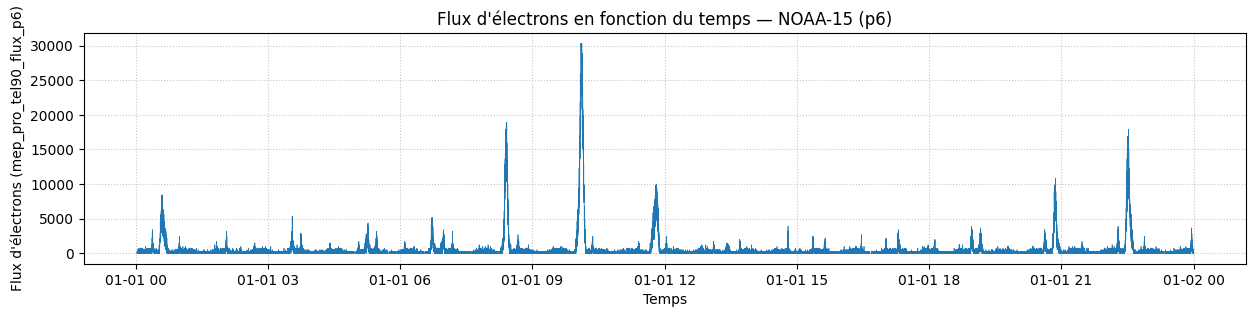

In [11]:
plt.figure(figsize=(15, 3))
plt.plot(df_noaa.index, df_noaa["flux_p6"], lw=0.5)
plt.xlabel("Temps")
plt.ylabel("Flux d'électrons (mep_pro_tel90_flux_p6)")
plt.title("Flux d'électrons en fonction du temps — NOAA-15 (p6)")
plt.grid(True)
#plt.yscale("log")  # souvent utile pour les flux
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()


Tracer L-shell en fonction du temps

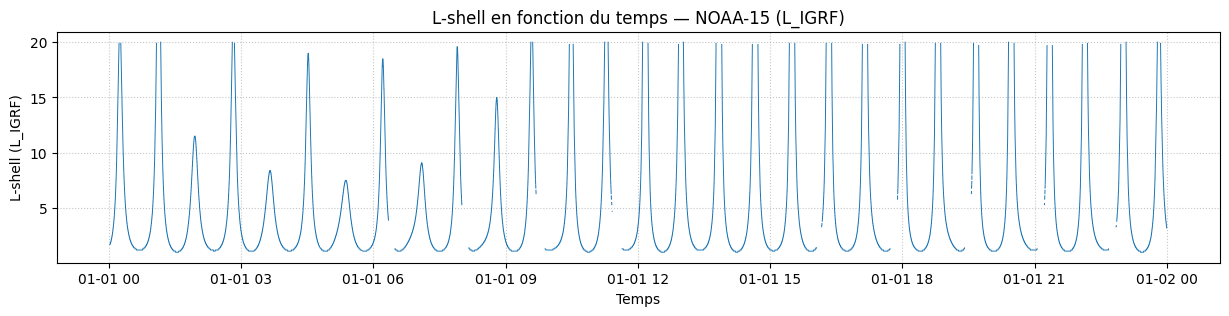

In [12]:
plt.figure(figsize=(15, 3))
plt.plot(df_noaa.index, df_noaa["L_IGRF"], lw=0.7)
plt.xlabel("Temps")
plt.ylabel("L-shell (L_IGRF)")
plt.title(f"L-shell en fonction du temps — NOAA-15 (L_IGRF)")
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

Maintenant qu'on a des résultats pour chaque variables, on va essayer de les rassembler

In [13]:
df_noaa = df_noaa.rename(columns={
    "L_IGRF": "L",
    "flux_p6": "flux"
})

# filtrer les flux positifs (log10 sinon)
df_noaa = df_noaa[df_noaa["flux"] > 0].copy()

# index "linéaire" pour l’axe x (0,1,2,...)
df_noaa = df_noaa.sort_index()
df_noaa["i"] = np.arange(len(df_noaa))

In [14]:
# Bins en L (approx comme ta figure: ~2.8 à ~5.8)
L_min, L_max, dL = 2.8, 5.8, 0.1
L_bins = np.arange(L_min, L_max + dL, dL)

# Bins en "temps" (ici indice i, tu peux augmenter/diminuer n_x_bins)
n_x_bins = 200
i_min, i_max = df_noaa["i"].min(), df_noaa["i"].max()
i_bins = np.linspace(i_min, i_max, n_x_bins + 1)

# Valeurs pour l’histogramme 2D
i_vals = df_noaa["i"].values
L_vals = df_noaa["L"].values
log_flux = np.log10(df_noaa["flux"].values)

# Somme pondérée par log10(flux) dans chaque bin
H_sum, x_edges, L_edges = np.histogram2d(
    i_vals, L_vals,
    bins=[i_bins, L_bins],
    weights=log_flux
)

# Nombre de points par bin (pour faire une moyenne)
H_count, _, _ = np.histogram2d(
    i_vals, L_vals,
    bins=[i_bins, L_bins]
)

# Moyenne du log10(flux) par bin
with np.errstate(invalid="ignore", divide="ignore"):
    H_mean = H_sum / H_count
    H_mean[H_count == 0] = np.nan  # bins vides => NaN


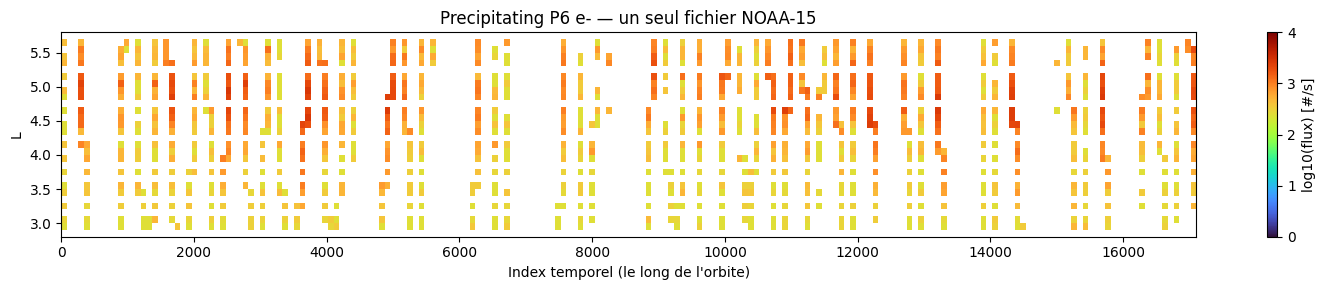

In [15]:
plt.figure(figsize=(15, 3))

# pcolormesh attend (X, Y, Z) avec Z.shape = (len(X)-1, len(Y)-1)
# H_mean a shape (len(i_bins)-1, len(L_bins)-1) -> on transpose pour avoir L en vertical
pcm = plt.pcolormesh(
    x_edges, L_edges, H_mean.T,
    shading="auto",
    vmin=0, vmax=4,
    cmap="turbo"  
)

plt.xlabel("Index temporel (le long de l'orbite)")
plt.ylabel("L")
plt.title("Precipitating P6 e- — un seul fichier NOAA-15")
cbar = plt.colorbar(pcm, label="log10(flux) [#/s]")
plt.tight_layout()
plt.show()


## Nous allons maintenant concaténer les fichiers des 5 dernières années et refaire le même processing

Imports + fonction qui charge un fichier .nc en DataFrame

In [16]:
import os
import glob
import numpy as np
import pandas as pd
from netCDF4 import Dataset

# Dossier racine où se trouvent 2020, 2021, 2022, 2023, 2024
BASE_DIR = r"C:\Users\gabri\OneDrive\Documents\IPSA\AERO5\Analyse_donnees_spatiales\PROJET\NCEI_NOAA15"

def load_noaa15_file(file_path):
    """
    Charge un fichier NOAA-15 .nc et renvoie un DataFrame
    indexé par le temps avec les colonnes :
      - L : L_IGRF
      - flux : mep_pro_tel90_flux_p6
    """
    print(f"Lecture du fichier : {os.path.basename(file_path)}")

    ds = Dataset(file_path, mode="r")

    # 1) Lecture des composantes de temps
    year = ds.variables['year'][:].astype(int)
    day  = ds.variables['day'][:].astype(int)   # jour de l'année (1..366)
    msec = ds.variables['msec'][:].astype(int)  # millisecondes depuis 00:00

    # 2) Lecture de L-shell et flux
    L = ds.variables['L_IGRF'][:].astype(float)
    flux = ds.variables['mep_pro_tel90_flux_p6'][:].astype(float)

    # 3) Gestion des fill values
    L_fill   = getattr(ds.variables['L_IGRF'], '_FillValue', None)
    flux_fill = getattr(ds.variables['mep_pro_tel90_flux_p6'], '_FillValue', None)

    if L_fill is not None:
        L[L == L_fill] = np.nan
    if flux_fill is not None:
        flux[flux == flux_fill] = np.nan

    ds.close()

    # 4) Construction du temps (vectorisé)
    year_s = pd.Series(year)
    day_s  = pd.Series(day)
    msec_s = pd.Series(msec)

    t0 = pd.to_datetime(year_s, format="%Y")
    time = t0 + pd.to_timedelta(day_s - 1, unit="D") + pd.to_timedelta(msec_s, unit="ms")

    # 5) DataFrame
    df = pd.DataFrame({
        "L": L,
        "flux": flux
    }, index=time)

    df.index.name = "time"

    # Nettoyage de base
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=["L", "flux"])

    return df


Boucle sur tous les fichiers 2020–2024 et concat

In [17]:
YEARS = [2020, 2021, 2022, 2023, 2024]

all_dfs = []

for year in YEARS:
    year_dir = os.path.join(BASE_DIR, str(year))
    nc_files = sorted(glob.glob(os.path.join(year_dir, "*.nc")))

    print(f"\n===== Année {year} : {len(nc_files)} fichier(s) trouvé(s) =====")

    for file_path in nc_files:
        try:
            df_year = load_noaa15_file(file_path)
            all_dfs.append(df_year)
        except Exception as e:
            print(f"  ⚠️ Problème avec {os.path.basename(file_path)} : {e}")

# Concaténation de tous les jours / années
df_all = pd.concat(all_dfs)
df_all = df_all.sort_index()

print("\nTaille finale du DataFrame sur 2020–2024 :", df_all.shape)
print(df_all.head())
print(df_all.tail())



===== Année 2020 : 366 fichier(s) trouvé(s) =====
Lecture du fichier : poes_n15_20200101_proc.nc
Lecture du fichier : poes_n15_20200102_proc.nc
Lecture du fichier : poes_n15_20200103_proc.nc
Lecture du fichier : poes_n15_20200104_proc.nc
Lecture du fichier : poes_n15_20200105_proc.nc
Lecture du fichier : poes_n15_20200106_proc.nc
Lecture du fichier : poes_n15_20200107_proc.nc
Lecture du fichier : poes_n15_20200108_proc.nc
Lecture du fichier : poes_n15_20200109_proc.nc
Lecture du fichier : poes_n15_20200110_proc.nc
Lecture du fichier : poes_n15_20200111_proc.nc
Lecture du fichier : poes_n15_20200112_proc.nc
Lecture du fichier : poes_n15_20200113_proc.nc
Lecture du fichier : poes_n15_20200114_proc.nc
Lecture du fichier : poes_n15_20200115_proc.nc
Lecture du fichier : poes_n15_20200116_proc.nc
Lecture du fichier : poes_n15_20200117_proc.nc
Lecture du fichier : poes_n15_20200118_proc.nc
Lecture du fichier : poes_n15_20200119_proc.nc
Lecture du fichier : poes_n15_20200120_proc.nc
Lecture d


--- Analyse des Outliers sur df_all (avant filtrage) ---
  L: 101322 outliers (0.157%) - Seuil: [1.030, 19.850]
  flux: 63080 outliers (0.098%) - Seuil: [0.000, 64268.293]

TOTAL unique observations à filtrer : 164402 (0.255%)


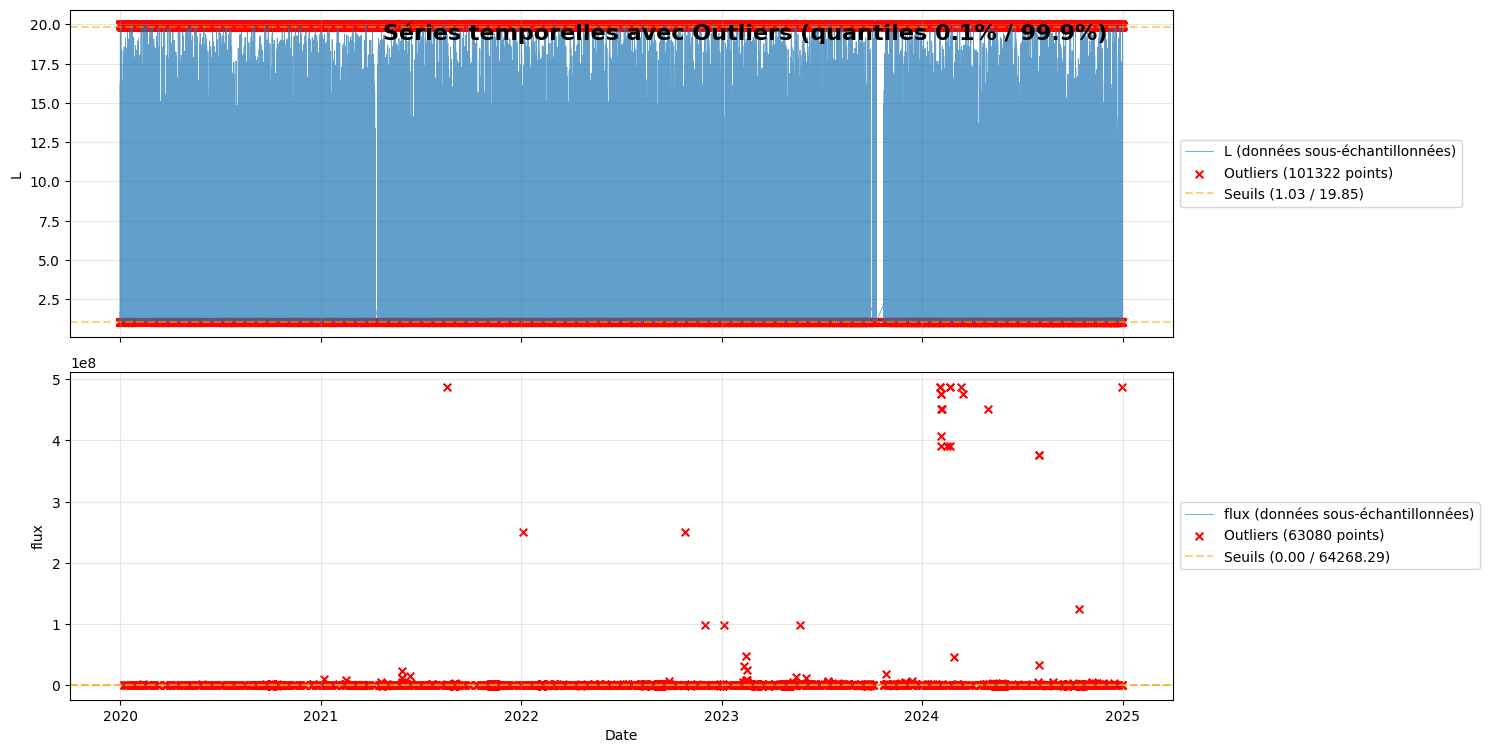

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ----------------------------------------------------
# A. ANALYSE ET DÉTECTION DES OUTLIERS
# ----------------------------------------------------

print("\n--- Analyse des Outliers sur df_all (avant filtrage) ---")

# Définir les colonnes à analyser pour les outliers
OUTLIER_COLS = ["L", "flux"]

# Calculer les seuils bas (0.1%) et haut (99.9%) sur l'ensemble des données
quantiles = df_all[OUTLIER_COLS].quantile([0.001, 0.999])

# Initialiser le masque général des outliers à False
outlier_mask = pd.Series(False, index=df_all.index)

# Calculer les masques spécifiques pour chaque colonne et les afficher
for col in OUTLIER_COLS:
    q_low = quantiles.loc[0.001, col]
    q_high = quantiles.loc[0.999, col]
    
    # Masque pour les valeurs en dehors des seuils
    col_mask = (df_all[col] < q_low) | (df_all[col] > q_high)
    
    # Afficher le résumé
    n_out = col_mask.sum()
    pct = 100 * n_out / len(df_all)
    print(f"  {col}: {n_out:5d} outliers ({pct:.3f}%) - Seuil: [{q_low:.3f}, {q_high:.3f}]")
    
    # Mettre à jour le masque général (OR logique)
    outlier_mask = outlier_mask | col_mask

# Compter le total des observations uniques identifiées comme outliers
total_outliers_count = outlier_mask.sum()
print(f"\nTOTAL unique observations à filtrer : {total_outliers_count} ({100 * total_outliers_count / len(df_all):.3f}%)")


# ----------------------------------------------------
# B. VISUALISATION DES OUTLIERS SUR LA SÉRIE TEMPORELLE
# ----------------------------------------------------

# 1. Downsampling pour le plot de la ligne principale (~100k points max)
n_cols_NOAA = len(OUTLIER_COLS)
downsample_factor = max(1, len(df_all) // 100000) 
ds_indices = np.arange(0, len(df_all), downsample_factor)

# Crée le DataFrame sous-échantillonné pour le tracé de la ligne bleue (plus rapide)
df_plot = df_all.iloc[ds_indices]

# 2. Configuration du Plot
fig, axs = plt.subplots(n_cols_NOAA, 1, figsize=(15, 4*n_cols_NOAA), sharex=True)
fig.suptitle("Séries temporelles avec Outliers (quantiles 0.1% / 99.9%)", 
             fontsize=16, fontweight='bold', y=0.92)

if n_cols_NOAA == 1:
    axs = [axs]

# 3. Boucle de Plot
for i, col in enumerate(OUTLIER_COLS):
    ax = axs[i]
    
    # Récupérer les seuils
    q_low = quantiles.loc[0.001, col]
    q_high = quantiles.loc[0.999, col]
    
    # Récupérer le masque spécifique à la colonne pour le scatter plot
    mask = (df_all[col] < q_low) | (df_all[col] > q_high)
    
    # A. TRACER LA SÉRIE PRINCIPALE (Downsampled - Ligne Bleue)
    ax.plot(df_plot.index, df_plot[col].values, 
            color='tab:blue', lw=0.6, label=f'{col} (données sous-échantillonnées)',
            alpha=0.7)
    
    # B. MARQUER LES OUTLIERS (Croix Rouges)
    if mask.any():
        df_outliers = df_all[mask]
        
        ax.scatter(df_outliers.index, df_outliers[col],
                    color='red', marker='x', s=30,
                    label=f'Outliers ({mask.sum()} points)')
        
    # C. AJOUTER LES LIGNES DE SEUIL
    ax.axhline(y=q_low, color='orange', linestyle='--', alpha=0.5,
               label=f'Seuils ({q_low:.2f} / {q_high:.2f})')
    ax.axhline(y=q_high, color='orange', linestyle='--', alpha=0.5)
    
    # Configuration de l'axe
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Ajustements finaux
plt.xlabel('Date')
plt.tight_layout()
plt.show()

Masquer les outliers

In [19]:
# --- 1. Suppression des outliers statistiques (Méthode B) ---

# Création d'une nouvelle variable pour les données filtrées
df_filtered = df_all[~outlier_mask].copy()

total_outliers_count = outlier_mask.sum()
print(f"Taille du DataFrame avant filtrage : {df_all.shape}")
print(f"Taille du DataFrame après suppression des outliers ({total_outliers_count} points) : {df_filtered.shape}")


# --- 2. Nettoyage Physique et Binning (Suite de votre pipeline) ---

# Remplacement de l'ancien 'final_df' par la version filtrée
final_df = df_filtered.reset_index()  # colonne "time"

# Nettoyage physique (déjà dans votre code, important de le garder)
final_df = final_df[
    (final_df["L"] >= 1.0) &
    (final_df["L"] <= 7.0) &
    (final_df["flux"] > 0)
].copy()

# 3) Bin temporel de 12 h
final_df["date_bin"] = final_df["time"].dt.floor("12h")
    
# 4) L_binned : L arrondi au dixième
final_df["L_binned"] = (final_df["L"] / 0.1).round() * 0.1

# 5) Moyenne du flux P6, de L et du temps par bin (12h, L_binned)
grouped = final_df.groupby(["date_bin", "L_binned"]).agg({
    "flux": "mean",
    "L": "mean"
}).reset_index()

# 6) On force L = L_binned (pour la cohérence)
grouped["L"] = grouped["L_binned"]

print("\nDataFrame 'grouped' (filtré et agrégé) créé avec succès.")

# Le DataFrame 'grouped' est maintenant prêt pour l'analyse statistique et la modélisation.

Taille du DataFrame avant filtrage : (64363393, 2)
Taille du DataFrame après suppression des outliers (164402 points) : (64198991, 2)

DataFrame 'grouped' (filtré et agrégé) créé avec succès.


In [20]:
grouped

,date_bin,L_binned,flux,L
0,2020-01-01 00:00:00,1.0,274.390240,1.0
1,2020-01-01 00:00:00,1.1,276.958810,1.1
2,2020-01-01 00:00:00,1.2,2334.793796,1.2
3,2020-01-01 00:00:00,1.3,7321.159198,1.3
4,2020-01-01 00:00:00,1.4,7698.525297,1.4
...,...,...,...,...
220202,2024-12-31 12:00:00,6.6,379.403792,6.6
220203,2024-12-31 12:00:00,6.7,418.118465,6.7
220204,2024-12-31 12:00:00,6.8,258.249637,6.8
220205,2024-12-31 12:00:00,6.9,308.943087,6.9


In [21]:
# Construire un index entier pour les intervalles 12h
unique_bins = np.sort(grouped["date_bin"].unique())
bin_to_idx = {t: i for i, t in enumerate(unique_bins)}

grouped["t_index"] = grouped["date_bin"].map(bin_to_idx)

print(grouped[["date_bin", "t_index", "L_binned", "flux"]].head())


    date_bin  t_index  L_binned         flux
0 2020-01-01        0       1.0   274.390240
1 2020-01-01        0       1.1   276.958810
2 2020-01-01        0       1.2  2334.793796
3 2020-01-01        0       1.3  7321.159198
4 2020-01-01        0       1.4  7698.525297


Afficher les outliers

vmin, vmax flux pour LogNorm : 276.6654490001166 9355.325299696982


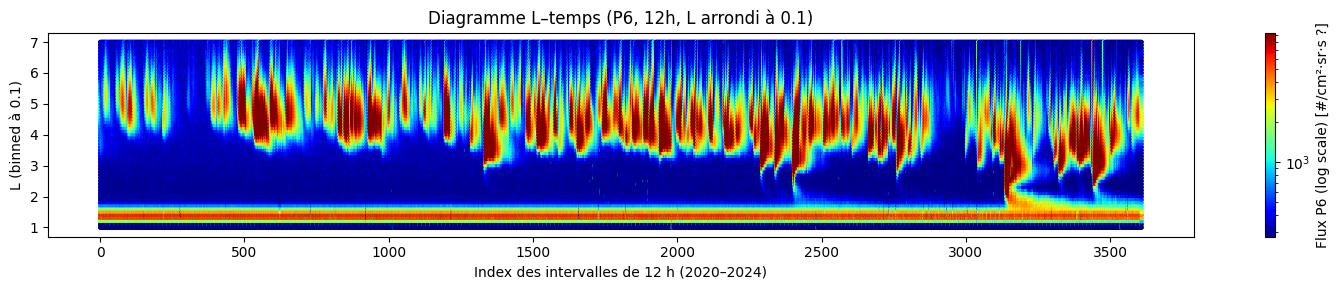

In [22]:
# Définir vmin et vmax pour l’échelle de couleur LogNorm
from matplotlib.colors import LogNorm


vmin = grouped["flux"].quantile(0.05)   # 5e percentile
vmax = grouped["flux"].quantile(0.95)   # 95e percentile

print("vmin, vmax flux pour LogNorm :", vmin, vmax)

plt.figure(figsize=(15, 3))

scatter = plt.scatter(
    grouped["t_index"],
    grouped["L_binned"],
    c=grouped["flux"],
    s=5,
    cmap="jet",
    norm=LogNorm(vmin=vmin, vmax=vmax)   # échelle log, comme chez le prof
)

cbar = plt.colorbar(scatter, label="Flux P6 (log scale) [#/cm²·sr·s ?]")
plt.xlabel("Index des intervalles de 12 h (2020–2024)")
plt.ylabel("L (binned à 0.1)")
plt.title("Diagramme L–temps (P6, 12h, L arrondi à 0.1)")
plt.tight_layout()
plt.show()


## Structure des ceintures de radiation.
On observe un flux d’électrons élevé et stable (couleurs chaudes : jaune/rouge) autour de L ≈ 3 et L ≈ 6.5. La couche basse (L ≈ 1.2) correspond à
la ceinture de radiation interne, où les électrons sont piégés par le champ magnétique terrestre.
La couche haute (L ≳ 4.5), avec des flux également importants, correspond à la ceinture de
radiation externe.

## Dynamique lors des tempêtes géomagnétiques. 
Lors des tempêtes les plus intenses (par
exemple autour des indices temporels ∼ 2400 ou ∼ 3200), on observe un phénomène où les
électrons atteignent des couches L plus basses que d’habitude. En temps calme, la « fente »,
ou zone de faible flux, se situe autour de L ≈ 2.5. Lors des tempêtes, on remarque que les flux
importants de la ceinture externe s’étendent temporairement vers des valeurs de L plus petites
(jusqu’à L ≈ 2.0 ou parfois 1.8). Ce changement de couche (diffusion radiale des électrons) est
un indicateur important de la perturbation de l’environnement spatial par l’activité solaire.

Calcul du percentile 95 %

In [23]:
# On supprime les flux nuls ou négatifs (rare mais possible)
valid_flux = grouped[grouped["flux"] > 0]["flux"]

threshold_95 = valid_flux.quantile(0.96)

print(f"Seuil du 95e percentile (flux P6) : {threshold_95:.2f}")
print(f"En notation log10 : {np.log10(threshold_95):.2f}")


Seuil du 95e percentile (flux P6) : 11103.31
En notation log10 : 4.05


Ajouter une colonne “event”, ça permet ensuite d’identifier :
- combien d’événements
- quand ils se produisent
- pour quelles valeurs de L

In [24]:
grouped["event"] = grouped["flux"] > threshold_95
grouped["event"].value_counts()

event
False    211398
True       8809
Name: count, dtype: int64

Visualisation des events sur le diagramme L–temps

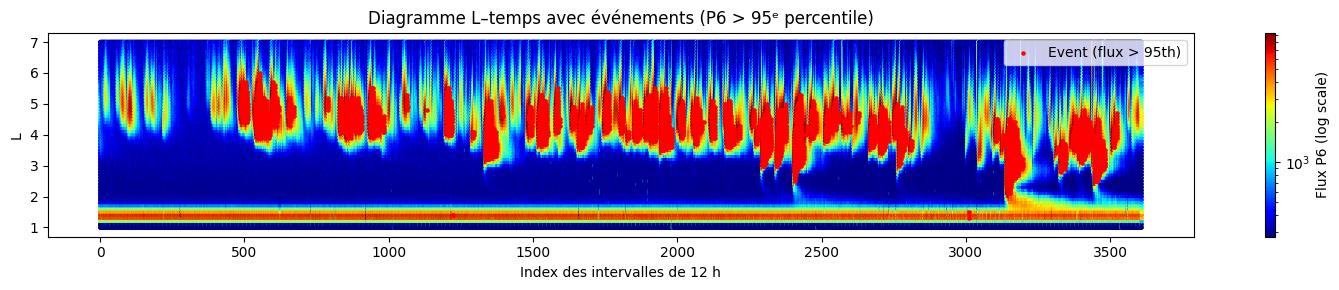

In [25]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(15,3))

sc = plt.scatter(
    grouped["t_index"],
    grouped["L_binned"],
    c=grouped["flux"],
    s=5,
    cmap="jet",
    norm=LogNorm(vmin=valid_flux.quantile(0.05),
                 vmax=valid_flux.quantile(0.95))
)

# Superposition des évènements
ev = grouped[grouped["event"] == True]
plt.scatter(
    ev["t_index"],
    ev["L_binned"],
    c="red",
    s=5,
    label="Event (flux > 95th)"
)

plt.colorbar(sc, label="Flux P6 (log scale)")
plt.xlabel("Index des intervalles de 12 h")
plt.ylabel("L")
plt.title("Diagramme L–temps avec événements (P6 > 95ᵉ percentile)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

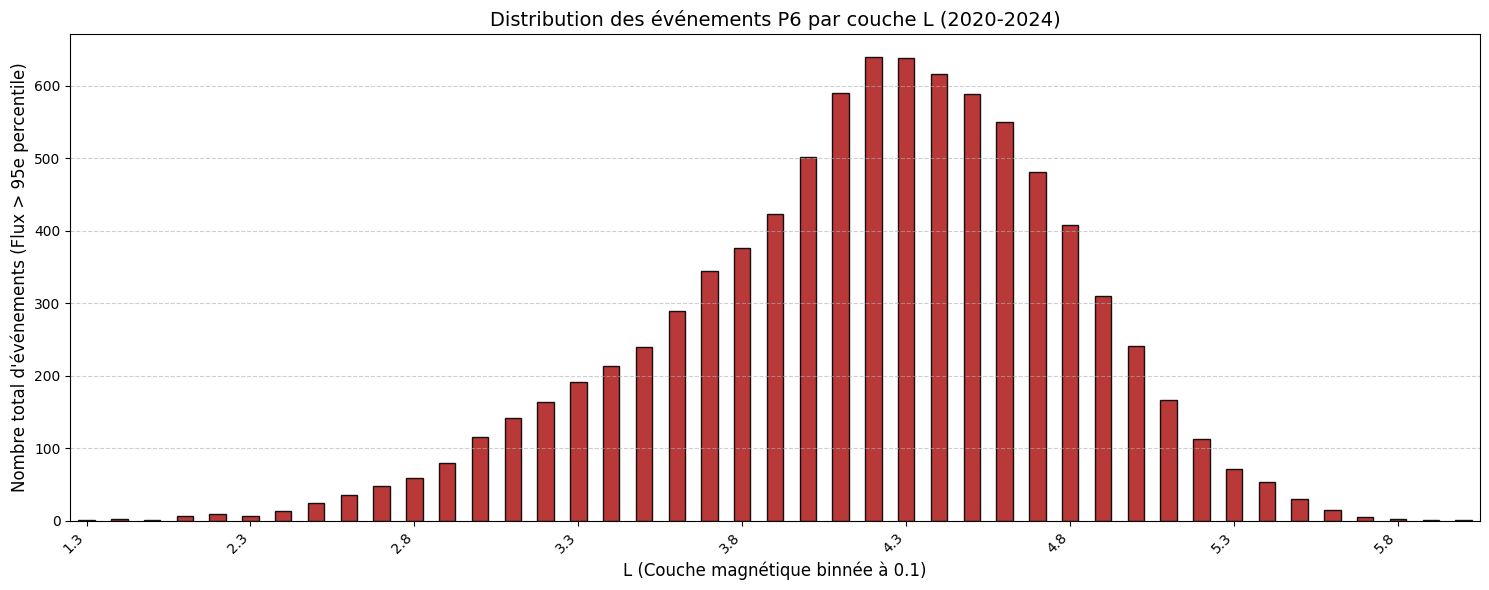

In [26]:
# --- Les variables 'grouped' et 'event' (calculées précédemment) sont utilisées ici ---

# 1. Filtrer le DataFrame pour ne garder que les événements (event == True)
events_only = grouped[grouped['event'] == True].copy()

# 2. Compter le nombre d'événements pour chaque tranche de L-shell (L_binned)
# On regroupe par L_binned et on compte le nombre d'occurrences.
event_counts_per_L = events_only.groupby('L_binned')['event'].count()

# 3. Créer la figure et le graphique à barres
plt.figure(figsize=(15, 6))
# plot(kind='bar') sur la série des comptages génère les barres de l'histogramme
event_counts_per_L.plot(kind='bar', color='#b22222', edgecolor='black', alpha=0.9) 

# 4. Configurer les titres et étiquettes
plt.xlabel('L (Couche magnétique binnée à 0.1)', fontsize=12)
plt.ylabel("Nombre total d'événements (Flux > 95e percentile)", fontsize=12)
plt.title("Distribution des événements P6 par couche L (2020-2024)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 5. Améliorer la lisibilité de l'axe des X (affichage des étiquettes L-shell tous les 5 bins)
n_bins = len(event_counts_per_L)
positions = np.arange(n_bins)

if n_bins > 30:
    # -----------------------------------------------------------
    # labels est maintenant un array de chaînes formatées à une décimale
    labels = event_counts_per_L.index.to_numpy()
    formatted_labels = [f"{l:.1f}" for l in labels] 
    # -----------------------------------------------------------
    plt.xticks(positions[::5], formatted_labels[::5], rotation=45, ha='right')
else:
    # Si moins de 30 bins, on formate simplement toutes les étiquettes
    formatted_labels = [f"{l:.1f}" for l in event_counts_per_L.index.to_numpy()]
    plt.xticks(positions, formatted_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

Le graphique confirme que le risque d'événement de flux élevé (Flux P6>95e percentile) est fortement corrélé à la localisation magnétique (L).

- Pic de Risque (L≈4.25): La majorité des événements se concentre autour de L≈4.25. Cette zone est au cœur de la ceinture de radiation externe, où les phénomènes d'accélération et de piégeage des électrons de 1 MeV sont les plus intenses en réponse à l'activité solaire.

- Seuil Critique (L≈3.0): Le nombre d'événements augmente significativement à partir de L≈3.0. La prédiction des événements est donc principalement une tâche de surveillance de la dynamique de la ceinture externe (L≥3.5).


Exporter les données en CSV

In [27]:
# # Préparer les données pour l'export CSV
# export_df = grouped.copy()

# # Ajouter la colonne log_flux
# export_df["log_flux"] = np.log10(export_df["flux"])

# # Renommer les colonnes pour clarté
# export_df = export_df.rename(columns={
#     "date_bin": "time_12h",
#     "t_index": "time_index",
#     "L_binned": "L"
# })

# # Sélectionner et ordonner les colonnes souhaitées
# export_df = export_df[["time_12h", "time_index", "L", "flux", "log_flux", "event"]]

# # Convertir la colonne 'event' en 0/1 (au lieu de True/False)
# export_df["event"] = export_df["event"].astype(int)

# # Exporter en CSV
# csv_path = r"C:\Users\gabri\OneDrive\Documents\IPSA\AERO5\Analyse_donnees_spatiales\PROJET\export_noaa15_data.csv"
# export_df.to_csv(csv_path, index=False)

# print(f"✅ Données exportées avec succès : {csv_path}")
# print(f"Nombre de lignes : {len(export_df)}")
# print(f"\nAperçu des données :\n{export_df.head()}")

# Step 2

Data Omni:
Pour récupérer les datas Omni, nous allons utiliser la librairie sunpy: https://sunpy.org/
L'objectif est de d'éffectuer un pré-traitement des données pour nettoyer les coquilles qui peut y avoir et d'enregistrer le tout dans un fichier en .csv après avoir moyenner le tout sur 12 heures

# Importation des librairies

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

# Récupération de données

Nous cherchons donc dans un premier temps toutes les données du satellite Omni du 1 Janvier 2020 au 31 Décembre 2024
On choisit donc les fichiers correspondant à 1 heures sur chaque ligne.

In [29]:
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

trange = a.Time('2020/01/01', '2024/12/31')

dataset = a.cdaweb.Dataset('OMNI2_H0_MRG1HR')

result = Fido.search(trange, dataset)
print(result)


Results from 1 Provider:

10 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

    Dataset            Start time               End time       
--------------- ----------------------- -----------------------
OMNI2_H0_MRG1HR 2020-01-01 00:00:00.000 2020-06-30 23:00:00.000
OMNI2_H0_MRG1HR 2020-07-01 00:00:00.000 2020-12-31 23:00:00.000
OMNI2_H0_MRG1HR 2021-01-01 00:00:00.000 2021-06-30 23:00:00.000
OMNI2_H0_MRG1HR 2021-07-01 00:00:00.000 2021-12-31 23:00:00.000
OMNI2_H0_MRG1HR 2022-01-01 00:00:00.000 2022-06-30 23:00:00.000
OMNI2_H0_MRG1HR 2022-07-01 00:00:00.000 2022-12-31 23:00:00.000
OMNI2_H0_MRG1HR 2023-01-01 00:00:00.000 2023-06-30 23:00:00.000
OMNI2_H0_MRG1HR 2023-07-01 00:00:00.000 2023-12-31 23:00:00.000
OMNI2_H0_MRG1HR 2024-01-01 00:00:00.000 2024-06-30 23:00:00.000
OMNI2_H0_MRG1HR 2024-07-01 00:00:00.000 2024-12-31 23:00:00.000




Téléchargement des données

In [30]:
dl_files = Fido.fetch(result) # fichiers téléchargés
dl_files

Files Downloaded: 100%|██████████| 10/10 [00:00<00:00, 25.02file/s]


['C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20200101_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20200701_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20210101_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20210701_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20220101_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20220701_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20230101_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20230701_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20240101_v01.cdf', 'C:\\Users\\gabri\\sunpy\\data\\omni2_h0_mrg1hr_20240701_v01.cdf']

Les données téléchargées sont ensuite concaténées pour le transformer en dataframe via la librairie pandas

In [31]:
# On concatène toutes les données et on sauvegarde en un pd dataframe
ts = TimeSeries(dl_files, concatenate=True)
df_sunpy = ts.to_dataframe()

L'objectif maintenant et de trier seulement les données qui nous seront nécessaires à savoir: Le vent solaire, Le champ magnétique interplanétaire et enfin le flux solaire

In [32]:
#On cherche les colonne ayant le nom correspondant à ce que l'on cherche
df_sunpy.columns.tolist()

['ABS_B',
 'AE',
 'AL_INDEX',
 'AP_INDEX',
 'AU_INDEX',
 'BX_GSE',
 'BY_GSE',
 'BY_GSM',
 'BZ_GSE',
 'BZ_GSM',
 'Beta',
 'DST',
 'Day',
 'E',
 'F',
 'F10_INDEX',
 'HR',
 'IMF',
 'IMF_PTS',
 'KP',
 'MFLX',
 'Mach_num',
 'Mgs_mach_num',
 'N',
 'PC_N_INDEX',
 'PHI-V',
 'PHI_AV',
 'PLS',
 'PLS_PTS',
 'PR-FLX_1',
 'PR-FLX_10',
 'PR-FLX_2',
 'PR-FLX_30',
 'PR-FLX_4',
 'PR-FLX_60',
 'Pressure',
 'Proton_QI',
 'R',
 'Ratio',
 'Rot#',
 'SIGMA-ABS_B',
 'SIGMA-B',
 'SIGMA-Bx',
 'SIGMA-By',
 'SIGMA-Bz',
 'SIGMA-N',
 'SIGMA-PHI-V',
 'SIGMA-T',
 'SIGMA-THETA-V',
 'SIGMA-V',
 'SIGMA-ratio',
 'Solar_Lyman_alpha',
 'T',
 'THETA-V',
 'THETA_AV',
 'V',
 'YR']

In [33]:
#On récupère seulement les données que l'on veut
df_sunpy = df_sunpy[["V", "BZ_GSM", "F10_INDEX"]]
df_sunpy.head()

,V,BZ_GSM,F10_INDEX
Epoch,,,
2020-01-01 00:00:00,295.0,-0.3,69.400002
2020-01-01 01:00:00,299.0,0.8,69.400002
2020-01-01 02:00:00,300.0,-0.3,69.400002
2020-01-01 03:00:00,298.0,-0.0,69.400002
2020-01-01 04:00:00,302.0,1.6,69.400002


Ainsi, on a dans notre dataframe tout ce que l'on cherche où:    V = Vitesse du Vent solaire
                                                                 BZ_GSM = Champs magnétique interplanétaire
                                                                 F10_INDEX = Flux Solaire

Maintenant que notre dataframe, il faut maintenant nettoyer les outliers et les NaN

# Verification des NaN

In [34]:
missing = df_sunpy.isna().sum()
missing_percent = 100 * missing / len(df_sunpy)
missing_table = pd.DataFrame({"Missing values": missing, "%": missing_percent})
print(missing_table.sort_values(by="%", ascending=False))

           Missing values         %
V                     654  1.491516
BZ_GSM                351  0.800493
F10_INDEX              24  0.054735


On a jusqu'à 1.5% de NaN dans notre DataFrame il faut donc les enlever

# Tracé des NaN en fonction du temps

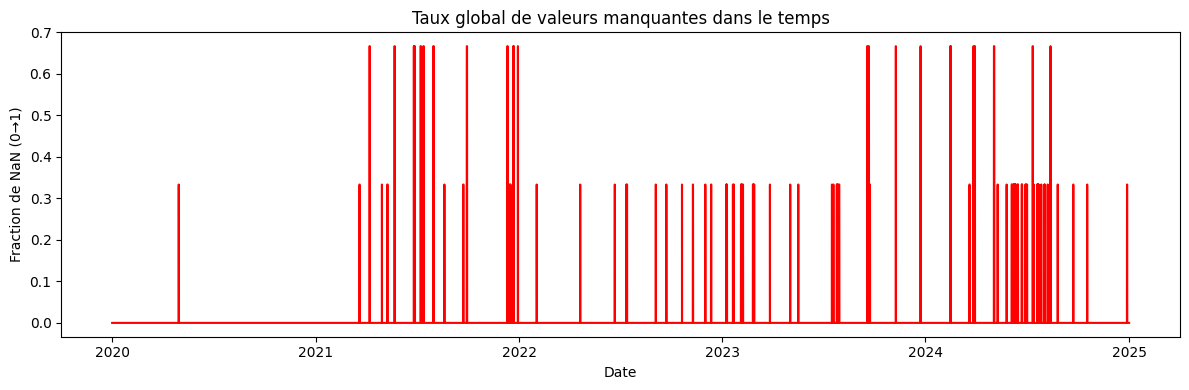

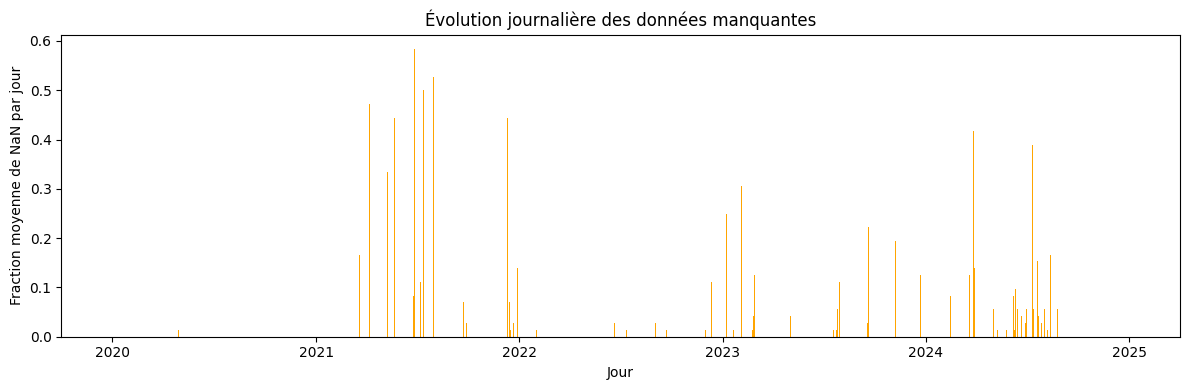

In [35]:
# fraction de NaN (toutes colonnes confondues) par heure
nan_frac = df_sunpy.isna().mean(axis=1)

plt.figure(figsize=(12,4))
plt.plot(nan_frac.index, nan_frac.values, color='red')
plt.ylabel("Fraction de NaN (0→1)")
plt.xlabel("Date")
plt.title("Taux global de valeurs manquantes dans le temps")
plt.tight_layout()
plt.show()

# fraction de NaN (toutes colonnes confondues) par jour
nan_daily = df_sunpy.isna().mean(axis=1).resample("1D").mean()

plt.figure(figsize=(12,4))
plt.bar(nan_daily.index, nan_daily.values, width=1.0, color='orange')
plt.ylabel("Fraction moyenne de NaN par jour")
plt.xlabel("Jour")
plt.title("Évolution journalière des données manquantes")
plt.tight_layout()
plt.show()

La présence de NaN n'a pas l'air cyclique donc on peut simplement supprimer les NaN

# Suppression des NaN

In [36]:
df_sunpy = df_sunpy.dropna()
df_sunpy = df_sunpy.reset_index()

# On relance pour vérifier si on a des NAn
missing = df_sunpy.isna().sum()
missing_percent = 100 * missing / len(df_sunpy)
missing_table = pd.DataFrame({"Missing values": missing, "%": missing_percent})
print(missing_table.sort_values(by="%", ascending=False))

           Missing values    %
Epoch                   0  0.0
V                       0  0.0
BZ_GSM                  0  0.0
F10_INDEX               0  0.0


Le taux de NaN est maintenant de 0% donc ils sont bien supprimés

# Outliers

On peut tracer nos valeurs en fonction du temps et voir s'il existe des outliers

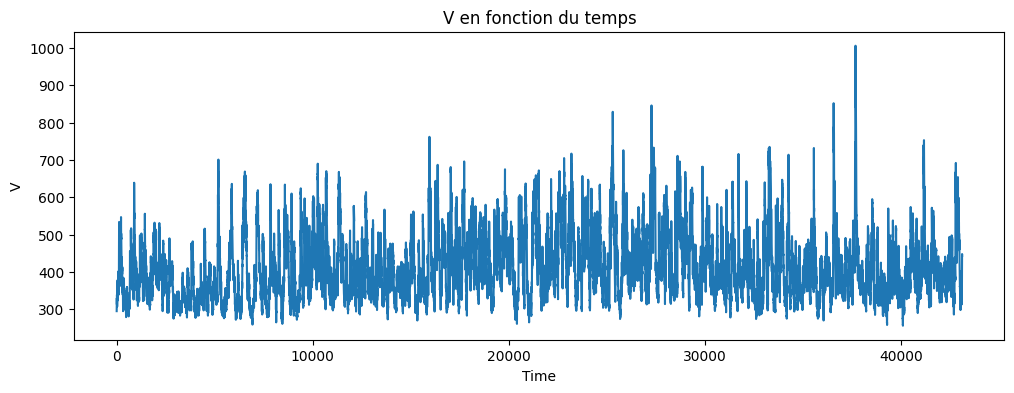

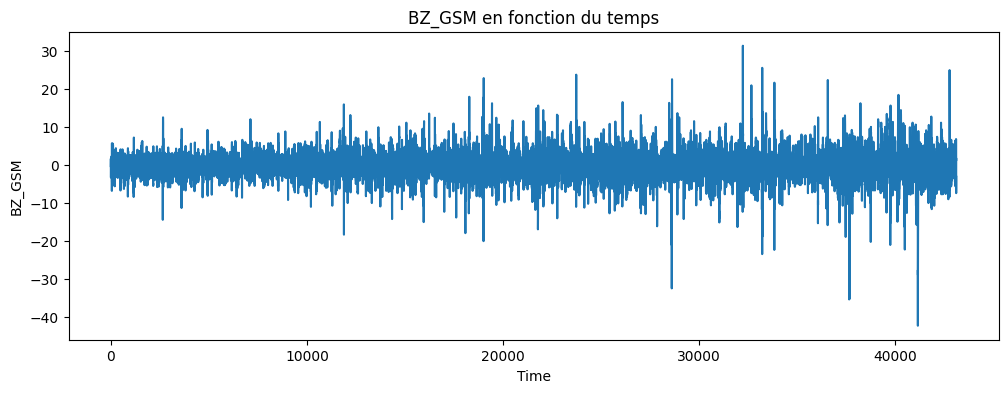

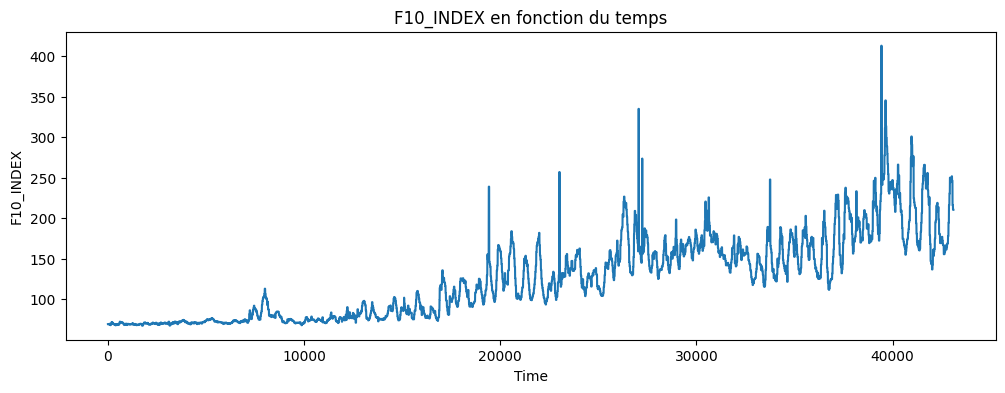

In [37]:
# Graphique vitesse des vents solaires en fonction du temps
plt.figure()
df_sunpy['V'].plot(figsize=(12,4))
plt.xlabel("Time")
plt.ylabel("V")
plt.title("V en fonction du temps")
plt.show()

# Graphique champs magnétique interplanétaire en fonction du temps
plt.figure()
df_sunpy['BZ_GSM'].plot(figsize=(12,4))
plt.xlabel("Time")
plt.ylabel("BZ_GSM")
plt.title("BZ_GSM en fonction du temps")
plt.show()

# Graphique flux solaire en fonction du temps
plt.figure()
df_sunpy['F10_INDEX'].plot(figsize=(12,4))
plt.xlabel("Time")
plt.ylabel("F10_INDEX")
plt.title("F10_INDEX en fonction du temps")
plt.show()

# Ditribution

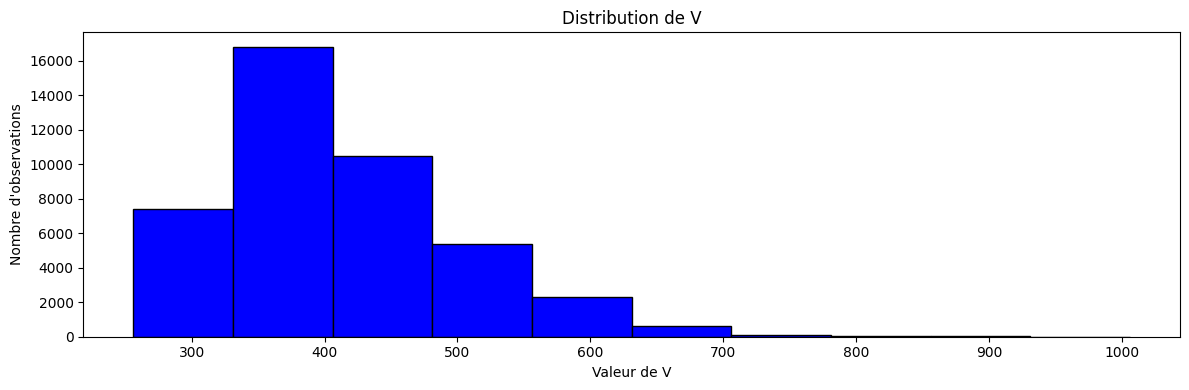

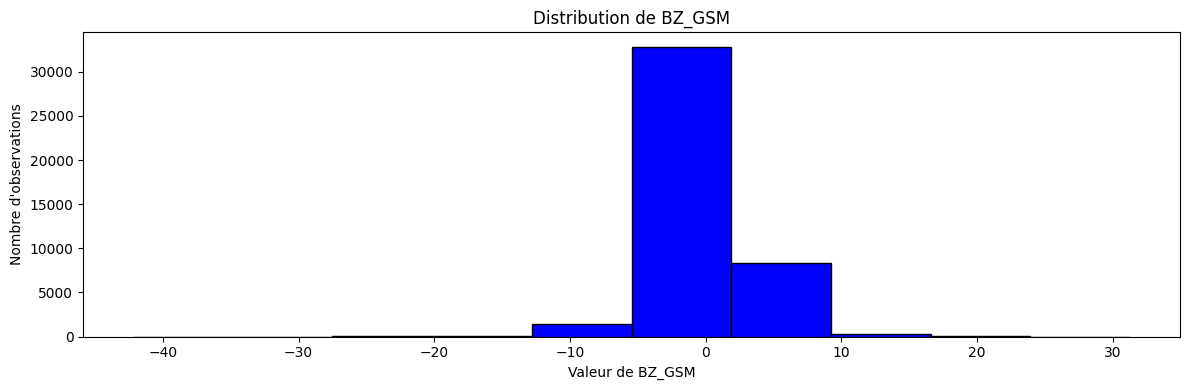

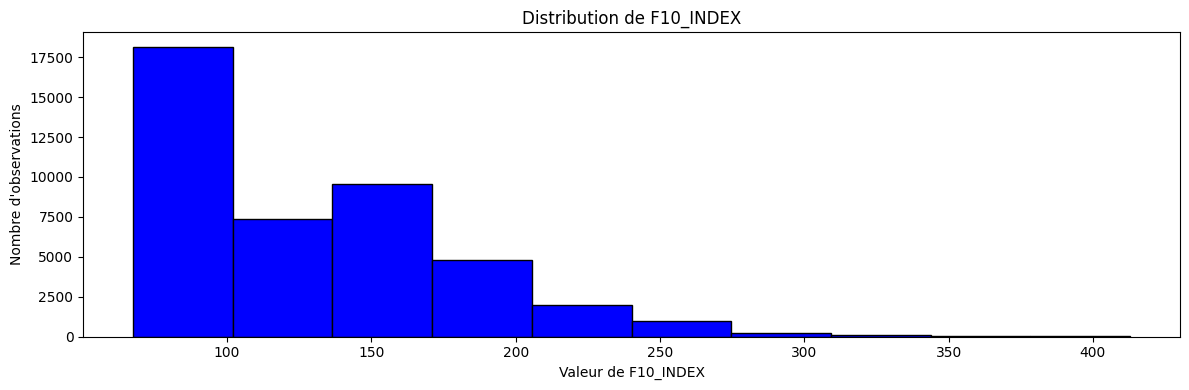

In [38]:
columns_to_plot = ["V", "BZ_GSM", "F10_INDEX"]

for col in columns_to_plot:
    plt.figure(figsize=(12,4))
    plt.hist(df_sunpy[col], color='blue', edgecolor='black')
    plt.title(f"Distribution de {col}")
    plt.xlabel(f"Valeur de {col}")
    plt.ylabel("Nombre d'observations")
    plt.tight_layout()
    plt.show()

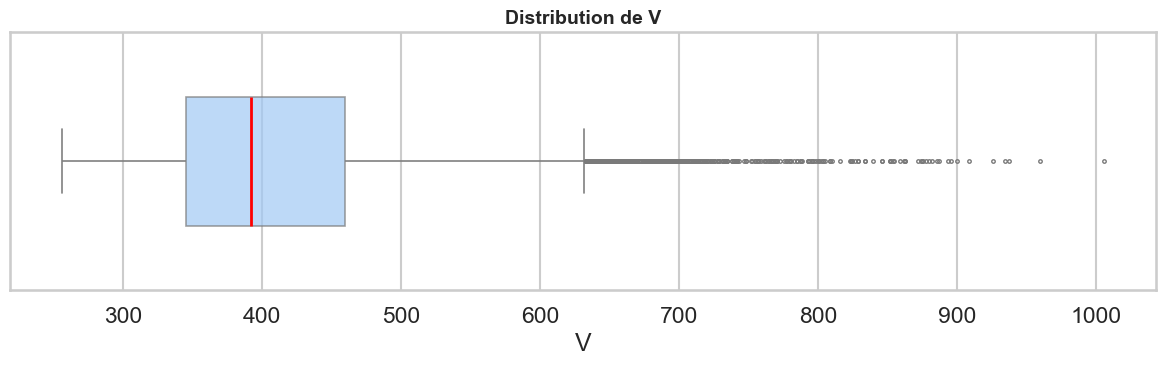

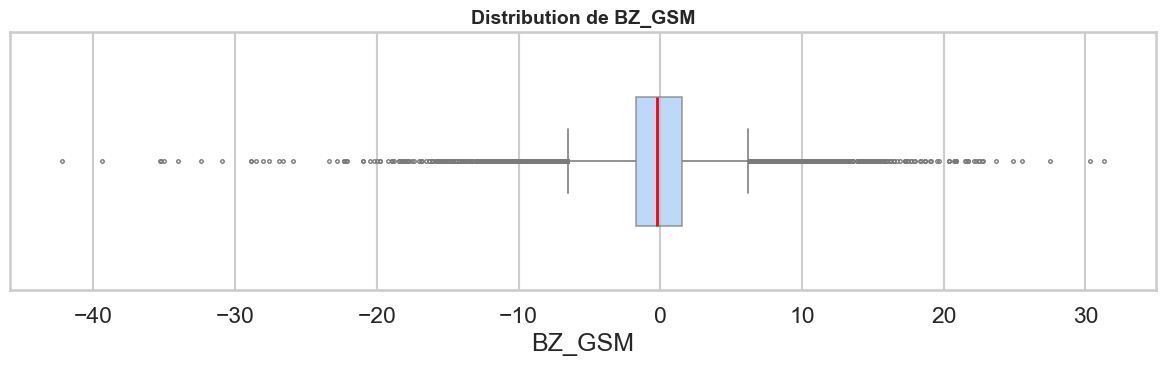

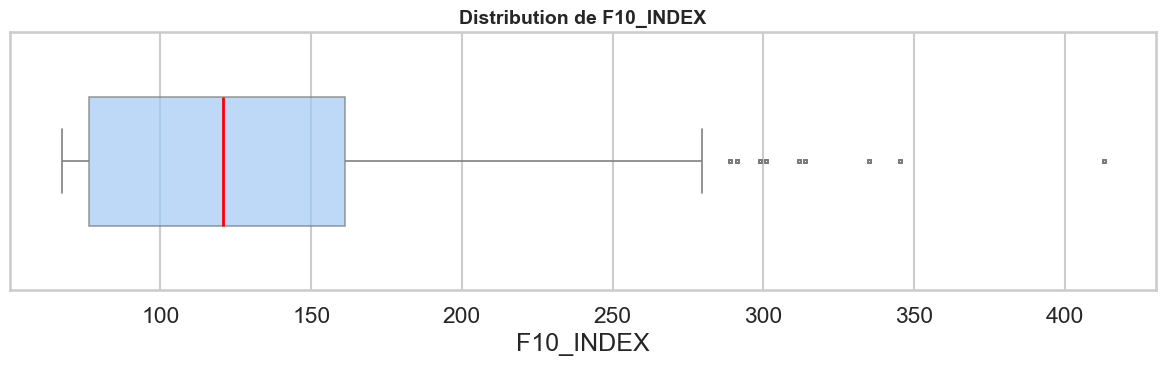

In [39]:
# Option esthétique globale (seaborn style)
sns.set(style="whitegrid", context="talk", palette="deep")
for col in columns_to_plot:
    plt.figure(figsize=(12,4))
    
    sns.boxplot(
        x=df_sunpy[col],
        color=sns.color_palette("pastel")[0],
        width=0.5,
        fliersize=2.5,      # taille des points outliers
        linewidth=1.2,
        boxprops=dict(alpha=0.7, facecolor=sns.color_palette("pastel")[0]),
        medianprops=dict(color="red", linewidth=2),
        whiskerprops=dict(color="gray", linewidth=1.2),
        capprops=dict(color="gray", linewidth=1.2)
    )
    
    plt.title(f"Distribution de {col}", fontsize=14, weight="bold")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Il n'y a pas l'air d'avoir d'ouliers aux premiers abords, créons un filtre physique afin de les supprimer ceux qu'on ne voit pas

# Application des filtres physiques

Pour valider les valeurs physique limites:
Vitesse Solar Wind: "At a distance of more than a few solar radii from the Sun, the solar wind reaches speeds of 250–750 km/s and is supersonic" (page wikipedia de solar wind)
https://en.wikipedia.org/wiki/Solar_wind

Solar Radio Flux: " Reported in “solar flux units”, (s.f.u.), the F10.7 can vary from below 50 s.f.u., to above 300 s.f.u., over the course of a solar cycle. " 
https://www.swpc.noaa.gov/phenomena/f107-cm-radio-emissions

Interplanetary magnetic field component: https://distantreader.org/stacks/journals/jnsps/jnsps-620.pdf


In [40]:
#Création des limites physique de nos données (En dehors de ces données, on les considère comme des outliers)
LIMITS = {
    "V":         (200.0, 750.0),   # km/s (vent solaire)
    "BZ_GSM":    (-30.0, 30.0), # nT
    "F10_INDEX": (50.0, 300.0), # s.f.u
}
print(f"Nombre de lignes AVANT filtrage : {len(df_sunpy):,}")

mask = pd.Series(True, index=df_sunpy.index)

for col, (lower, upper) in LIMITS.items():
    # S'assurer que la colonne existe dans le DataFrame
    if col in df_sunpy.columns:
        print(f"Application du filtre pour {col}: ({lower} à {upper})")
        
        # Mettre à jour le masque (ET logique)
        # La ligne reste 'True' SEULEMENT si elle était déjà 'True'
        mask &= df_sunpy[col].between(lower, upper)
    else:
        print(f"Attention : Colonne {col} non trouvée dans le DataFrame, filtre ignoré.")

# Appliquer le masque final au DataFrame
df_filtered = df_sunpy[mask].copy()

print(f"\nNombre de lignes APRÈS filtrage : {len(df_filtered):,}")
print(f"Lignes supprimées (outliers) : {len(df_sunpy) - len(df_filtered):,}")

Nombre de lignes AVANT filtrage : 43,103
Application du filtre pour V: (200.0 à 750.0)
Application du filtre pour BZ_GSM: (-30.0 à 30.0)
Application du filtre pour F10_INDEX: (50.0 à 300.0)

Nombre de lignes APRÈS filtrage : 42,855
Lignes supprimées (outliers) : 248


# Tracé des outliers

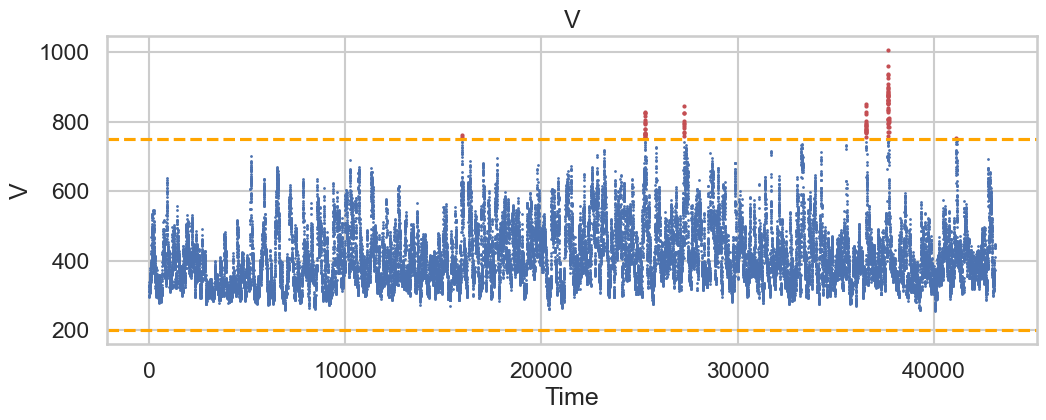

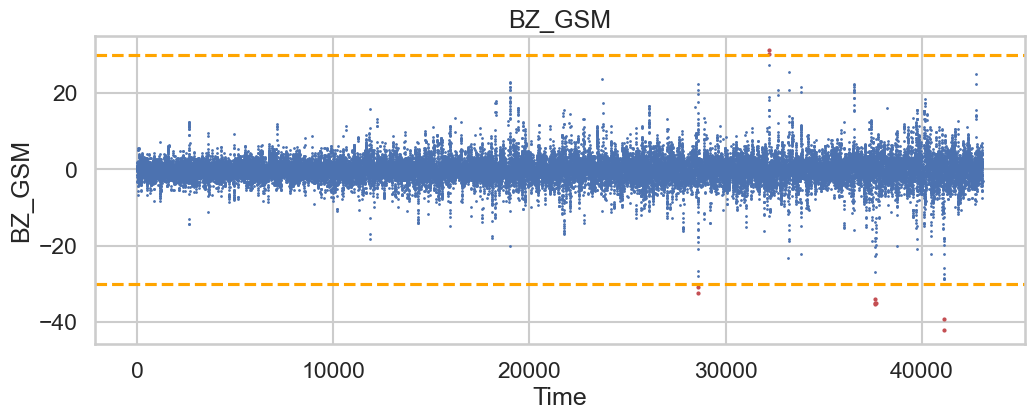

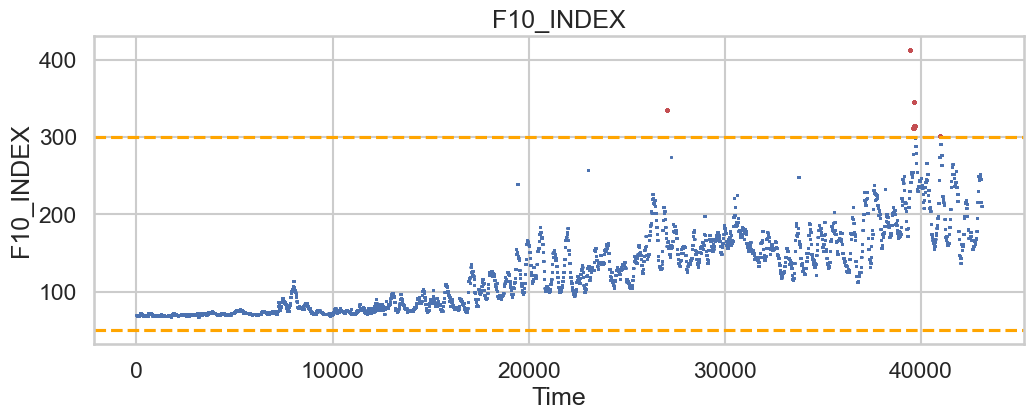

In [41]:
for col in columns_to_plot:
    low, high = LIMITS[f"{col}"]

    valid   = (df_sunpy[f"{col}"] >= low) & (df_sunpy[f"{col}"] <= high)
    invalid = ~valid

    plt.figure(figsize=(12,4))

    plt.plot(df_sunpy.index[valid], df_sunpy[f"{col}"][valid], '.', markersize=2)
    plt.plot(df_sunpy.index[invalid], df_sunpy[f"{col}"][invalid], 'r.', markersize=4)

    plt.axhline(low,  color='orange', linestyle='--')
    plt.axhline(high, color='orange', linestyle='--')

    plt.title(f"{col}")
    plt.xlabel("Time")
    plt.ylabel(f"{col}")
    plt.show()

# Tracé après filtrage

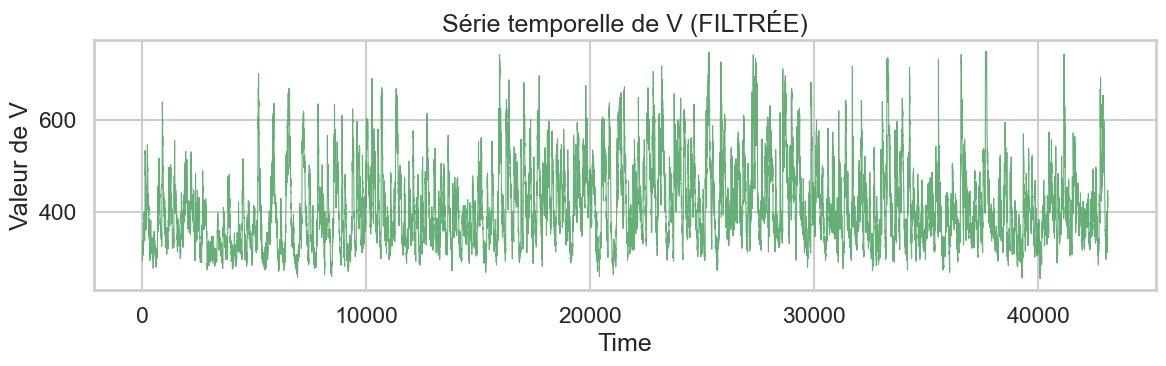

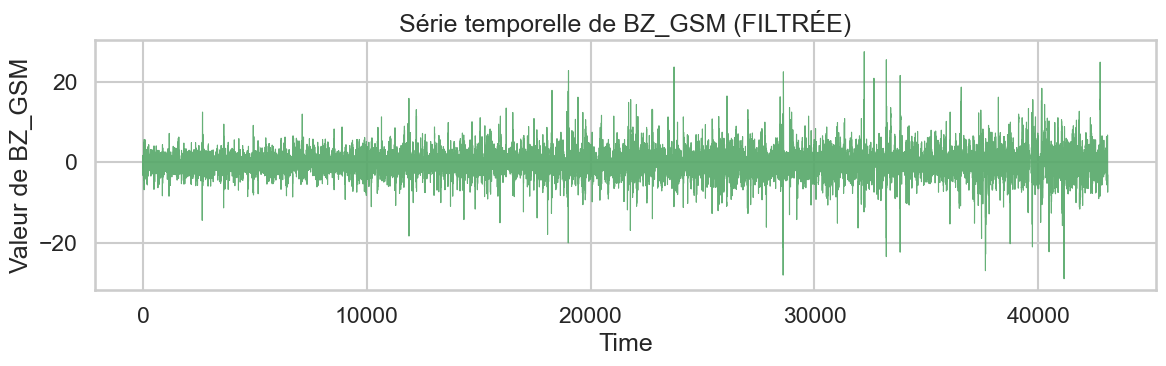

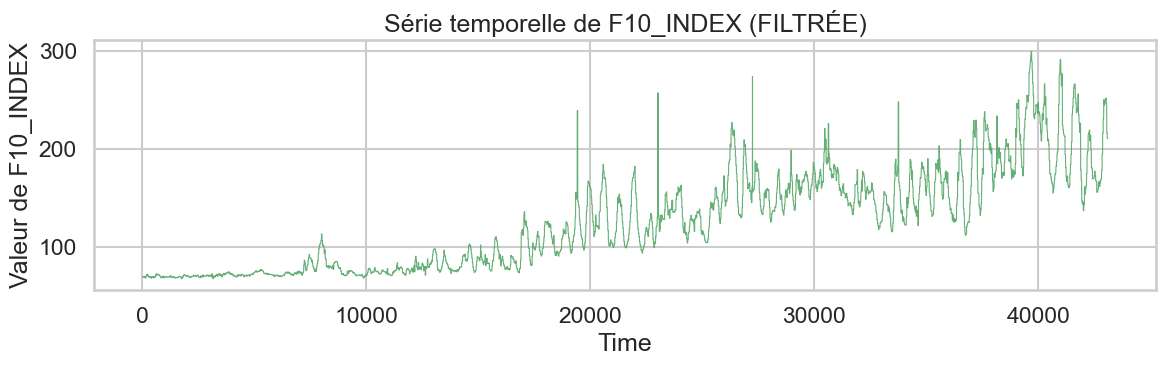

In [42]:
for col in columns_to_plot:
    plt.figure(figsize=(12, 4))
    # Notez l'utilisation de df_filtered
    plt.plot(
        df_filtered.index, 
        df_filtered[col], 
        color=sns.color_palette("deep")[2],
        linewidth=0.8,
        alpha=0.9,
    )

    plt.title(f"Série temporelle de {col} (FILTRÉE)")
    plt.xlabel("Time")
    plt.ylabel(f"Valeur de {col}")
    plt.tight_layout()
    plt.show()


Maintenant que nos données sont traitées ont peut moyenner sur 12 heures

# Moyennage sur 12 heures

In [43]:
df_filtered["Epoch"] = pd.to_datetime(df_filtered["Epoch"])
df_filtered = df_filtered.set_index("Epoch")
df_12h = df_filtered.resample("12H").mean()
df_12h.head()

,V,BZ_GSM,F10_INDEX
Epoch,,,
2020-01-01 00:00:00,312.000000,-0.516667,69.400002
2020-01-01 12:00:00,324.083344,0.125000,69.400002
2020-01-02 00:00:00,318.083344,0.200000,69.500000
2020-01-02 12:00:00,347.333344,-0.100000,69.500000
2020-01-03 00:00:00,346.000000,-0.766667,68.900002


# Application d'un Z-score

In [44]:
df_12h['BZ_GSM'] = (df_12h['BZ_GSM'] - df_12h['BZ_GSM'].mean()) / df_12h['BZ_GSM'].std()
df_12h['V'] = (df_12h['V'] - df_12h['V'].mean()) / df_12h['V'].std()

# Tracé du moyennage sur 12 heures

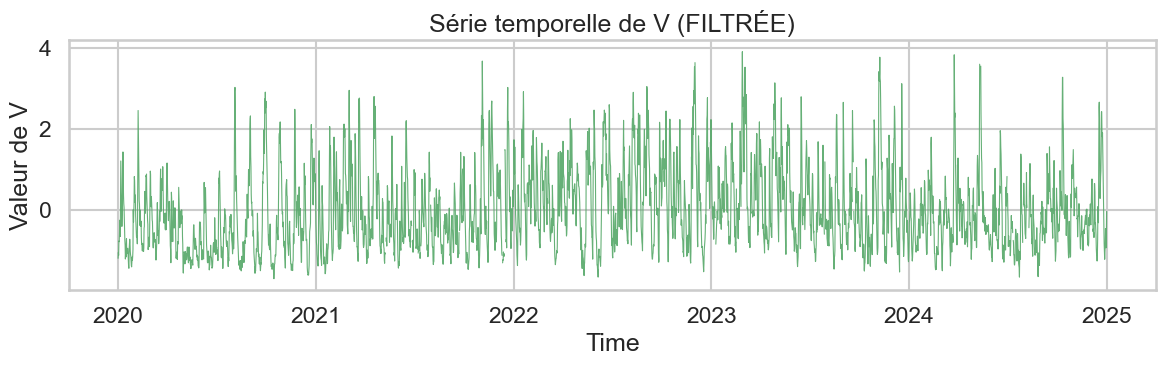

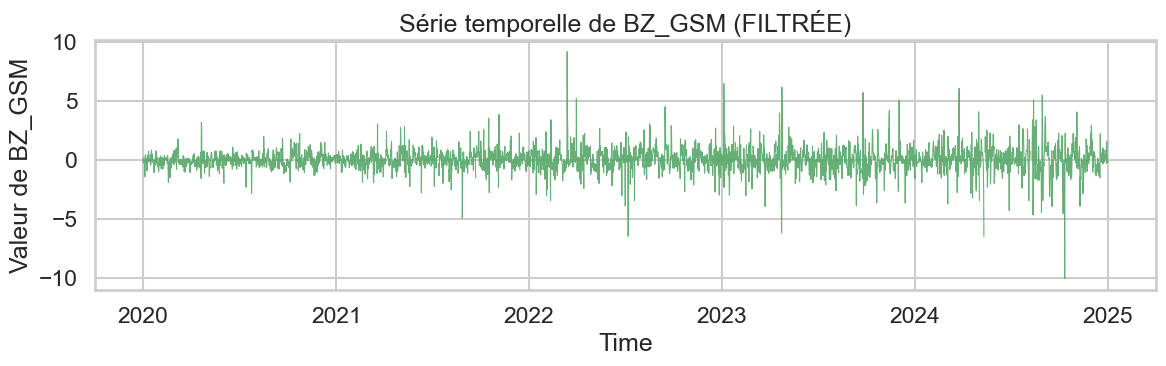

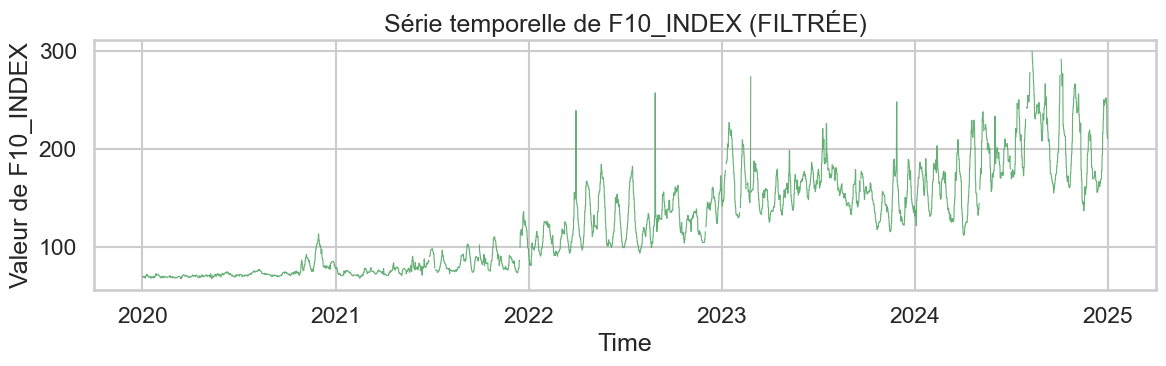

In [45]:
for col in columns_to_plot:
    plt.figure(figsize=(12, 4))
    # Notez l'utilisation de df_filtered
    plt.plot(
        df_12h.index, 
        df_12h[col], 
        color=sns.color_palette("deep")[2],
        linewidth=0.8,
        alpha=0.9,
    )

    plt.title(f"Série temporelle de {col} (FILTRÉE)")
    plt.xlabel("Time")
    plt.ylabel(f"Valeur de {col}")
    plt.tight_layout()
    plt.show()

Toutes les données sont traitées et moyennées, on peut donc enregistrer le tout dans un fichier CSV

# Enregistrement des données dans un fichier CSV

In [46]:
df_12h.to_csv(r"C:\Users\gabri\OneDrive\Documents\IPSA\AERO5\Analyse_donnees_spatiales\PROJET\omni_12h.csv")



## Machine Learning

A partir de maintenant nous pouvons passer au machine learning pour prédire les prochains flux solaires.

Pour se faire, nous allon importer nos données NOAA et Omni que nous allons assembler avant d'entraîner un modèle de machine learning en régression linéaire et ce pour chaque L différents

Enfin on pourra visualiser les résultats et porter des conclusions

# Importation des données Omni et NOAA

Data Omni:

In [47]:
df_omni = pd.read_csv("C:\\Users\\gabri\\OneDrive\\Documents\\IPSA\\AERO5\\Analyse_donnees_spatiales\\PROJET\\omni_12h.csv")
print("data omni: \n")
df_omni.head()

data omni: 



,Epoch,V,BZ_GSM,F10_INDEX
0,2020-01-01 00:00:00,-1.180486,-0.187843,69.4
1,2020-01-01 12:00:00,-1.034939,0.112784,69.4
2,2020-01-02 00:00:00,-1.107211,0.147922,69.5
3,2020-01-02 12:00:00,-0.754887,0.007369,69.5
4,2020-01-03 00:00:00,-0.770947,-0.304971,68.9


Data NOAA

In [48]:
print("data noaa: \n")
df_noaa = pd.read_csv(r"C:\Users\gabri\OneDrive\Documents\IPSA\AERO5\Analyse_donnees_spatiales\PROJET\noaa_p6_2020_2024_ML.csv",sep=";") #ne pas oublier le séparateur ;
df_noaa.head()

data noaa: 



,time_12h,time_index,L,flux,log_flux,event
0,01/01/2020 00:00,0,1.0,274.390240,2.438369,0
1,01/01/2020 00:00,0,1.1,276.958810,2.442415,0
2,01/01/2020 00:00,0,1.2,2334.793796,3.368249,0
3,01/01/2020 00:00,0,1.3,7321.159198,3.864580,0
4,01/01/2020 00:00,0,1.4,7698.525297,3.886408,0


# Préparation des données
L'objectif est d'adapter les données Omni pour les intégrer dans les données NOAA
On va donc multiplier 60 fois chaque ligne du dataframe de Omni pour avoir une données pour chaque L différents

In [49]:
df_omni['Epoch'] = pd.to_datetime(df_omni['Epoch'])
df_noaa['time_12h'] = pd.to_datetime(df_noaa['time_12h'], format='mixed', dayfirst=True)

counts_per_timestamp = df_noaa.groupby('time_12h').size().reset_index(name='count')

df_omni_with_counts = pd.merge(
    df_omni,
    counts_per_timestamp,
    left_on='Epoch',
    right_on='time_12h',
    how='left'
)

df_omni_expanded = df_omni_with_counts.loc[
    df_omni_with_counts.index.repeat(df_omni_with_counts['count'].fillna(0).astype(int))
].reset_index(drop=True)

# On trie en fonction du temps
df_noaa_sorted = df_noaa.sort_values('time_12h').reset_index(drop=True)
df_omni_expanded = df_omni_expanded.sort_values('time_12h').reset_index(drop=True)

# On regroupe les données avant de les retrier
df_model = pd.concat([df_noaa_sorted, df_omni_expanded.drop(['time_12h', 'count'], axis=1)], axis=1)
df_model = df_model.drop(columns=["Epoch","time_index"])
df_model = df_model.sort_values(['time_12h']).reset_index(drop=True)
df_model.head()

,time_12h,L,flux,log_flux,event,V,BZ_GSM,F10_INDEX
0,2020-01-01,1.0,274.390240,2.438369,0,-1.180486,-0.187843,69.4
1,2020-01-01,1.2,2334.793796,3.368249,0,-1.180486,-0.187843,69.4
2,2020-01-01,1.3,7321.159198,3.864580,0,-1.180486,-0.187843,69.4
3,2020-01-01,1.4,7698.525297,3.886408,0,-1.180486,-0.187843,69.4
4,2020-01-01,1.5,4663.218329,3.668686,0,-1.180486,-0.187843,69.4


# Entraînement du modèle de régression linéaire
On entraîne un modèle de régression linéaire pour chaque valeur de L entre 2.8 et 7.0

Pour entraîner notre modèle nous avons comme entrées: V, BZ_GSM et F10_INDEX, afin d'avoir des résultats concluants nous allons rajouter la valeur précédentes du flux

On sépare ensuite les données en données d'entraînement (60%), de validation (20%) et de test (20%). Cette répartition ne sera pas aléatoires mais dans l'ordre chronologique.

Enfin on pourra entraîner notre modèle et faire nos prédictions

In [50]:
R_carre=[]
L_list =[]
for i in range(28,71):
    i = i/10    
    df_L = df_model[(df_model['L'] > i - 0.05) & (df_model['L'] < i + 0.05)]
    # On créer une colonne décalée de 12 heures
    df_L["log_flux_12h_ago"] = df_L["log_flux"].shift(1)

    X = df_L.drop(columns=['flux','time_12h','L','log_flux', "event"]).copy()
    X = X.fillna(X.mean())
    y = df_L['log_flux'].reset_index(drop=True)


    n = len(X)
    train_end = int(0.6 * n)
    val_end = int(0.8 * n)

    # Split chronologique
    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]

    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]

    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]

    # Création du pipeline et entraînement sur le train set
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ])

    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train.to_numpy())
    y_val_pred = model.predict(X_val.to_numpy())
    y_test_pred = model.predict(X_test.to_numpy())

    #On enregistre les résultats pour L = 4.0 en guise d'exemple
    if i == 4.0:
        y_test_pred_L4 = y_test_pred
        y_test_L4 = y_test
        y_L4 = y
        y_train_L4 = y_train
        y_train_pred_L4 = y_train_pred
        y_val_L4 = y_val
        y_val_pred_L4 = y_val_pred

    # Enregistrement des résultats
    R_carre.append(r2_score(y_train, y_train_pred))
    L_list.append(i)


# Plot Prediction vs Données Réelles
Exemple pour L = 4.0

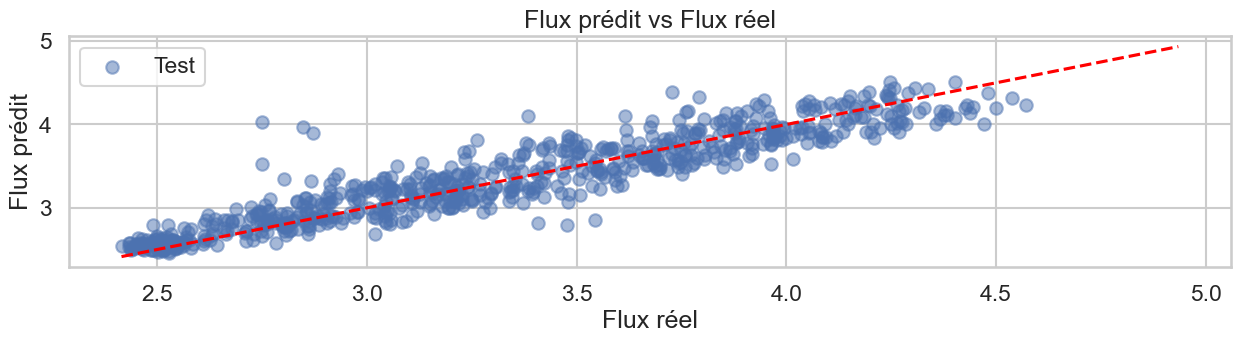

In [51]:
plt.figure(figsize=(15,3))
plt.scatter(y_test_L4, y_test_pred_L4, alpha=0.5, label='Test')

# Ligne y=x pour référence
min_val = min(y_L4.min(), y_L4.min())
max_val = max(y_L4.max(), y_L4.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel('Flux réel')
plt.ylabel('Flux prédit')
plt.title('Flux prédit vs Flux réel')
plt.legend()
plt.show()

# Plot en fonction du temps
Exemple pour L = 4.0

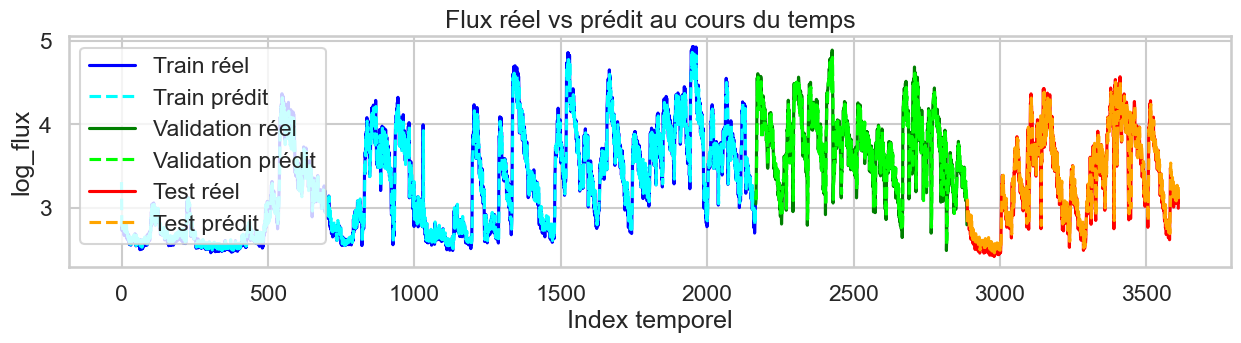

In [58]:
plt.figure(figsize=(15,3))
plt.plot(y_train_L4.index, y_train_L4, label='Train réel', color='blue')
plt.plot(y_train_L4.index, y_train_pred_L4, label='Train prédit', color='cyan', linestyle='--')

plt.plot(y_val_L4.index, y_val_L4, label='Validation réel', color='green')
plt.plot(y_val_L4.index, y_val_pred_L4, label='Validation prédit', color='lime', linestyle='--')

plt.plot(y_test_L4.index, y_test_L4, label='Test réel', color='red')
plt.plot(y_test_L4.index, y_test_pred_L4, label='Test prédit', color='orange', linestyle='--')

plt.xlabel('Index temporel')
plt.ylabel('log_flux')
plt.title('Flux réel vs prédit au cours du temps')
plt.legend()

# R**2 en fonction de L

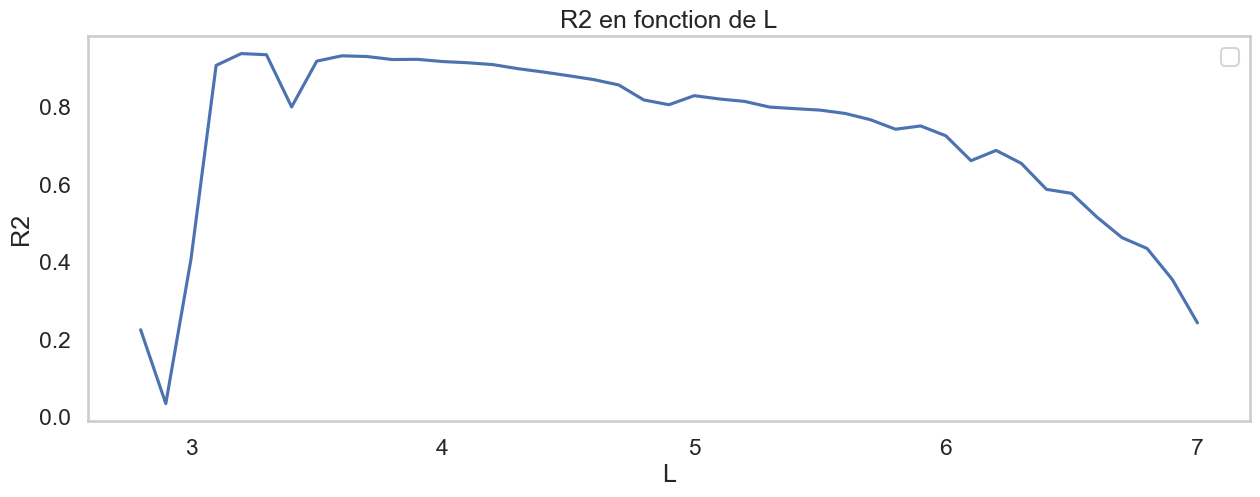

In [53]:
plt.figure(figsize=(15,5))
plt.plot(L_list, R_carre)
plt.xlabel('L')
plt.ylabel('R2')
plt.title('R2 en fonction de L')
plt.grid()
plt.legend()
plt.show()

# Classification

In [54]:

df_event = df_model.copy()

# Feature supplémentaire : flux 12h avant
df_event["event_12h_ago"] = df_event["event"].shift(1)

# X et y
X = df_event.drop(columns=['flux','time_12h','L','log_flux', "event"]).copy()
X = X.fillna(X.mean())
y = df_event['event'].reset_index(drop=True)

# Split chronologique
n = len(X)
train_end = int(0.6 * n)
test_end = int(1*n - 0.4 * n)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_test = X.iloc[:test_end]
y_test = y.iloc[:test_end]


classification = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

classification.fit(X_train, y_train)

# Probabilités prédites
y_proba = classification.predict_proba(X_test)[:,1]

# Classe finale (seuil = 0.5)
y_pred = (y_proba >= 0.5).astype(int)


# Score

In [55]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)

print("=== METRIQUES ===")
print(f"Accuracy : {acc:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUC ROC  : {auc_score:.3f}")

=== METRIQUES ===
Accuracy : 0.961
F1-score : 0.552
AUC ROC  : 0.833


# Plot

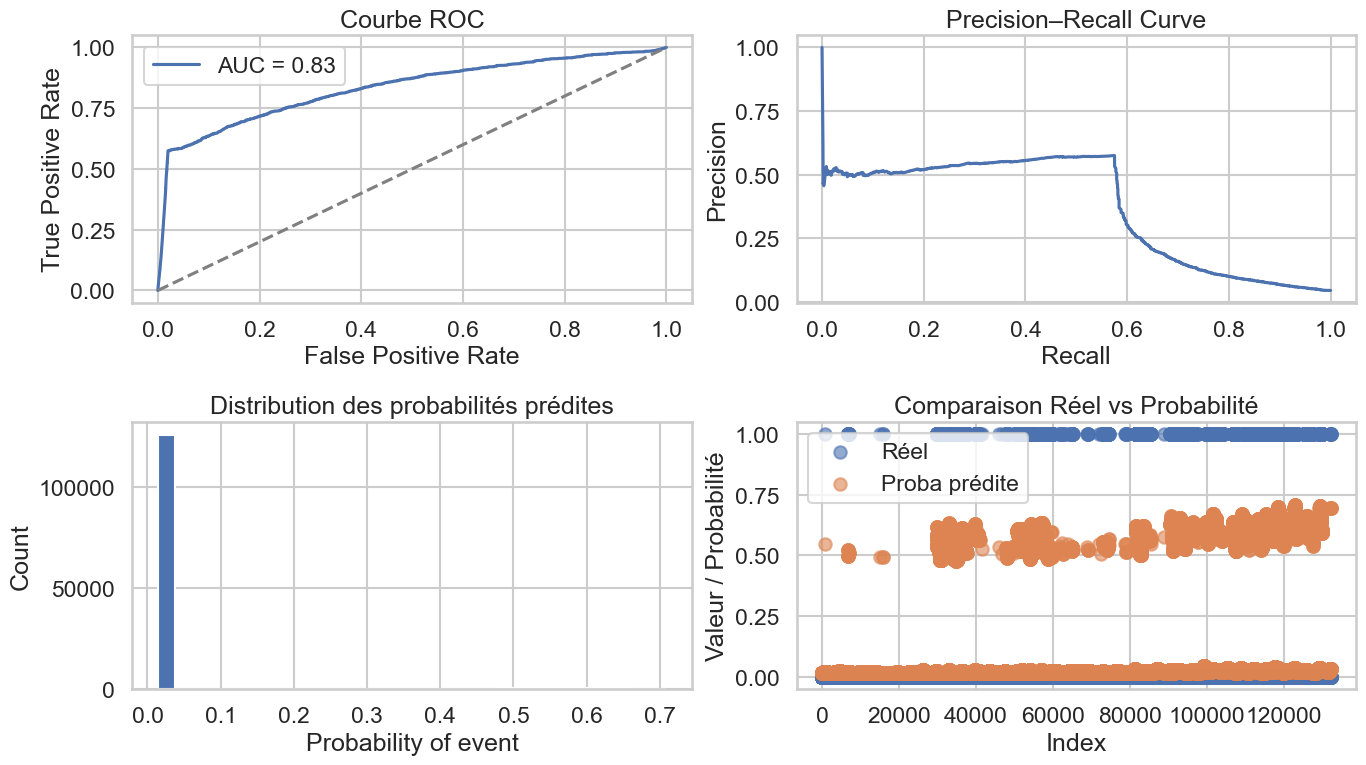

In [56]:
plt.figure(figsize=(14,8))

# Plot 1 : ROC
plt.subplot(2,2,1)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend()

# Plot 2 : Precision-Recall
plt.subplot(2,2,2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")

# Plot 3 : Histogramme des probabilités
plt.subplot(2,2,3)
plt.hist(y_proba, bins=30)
plt.xlabel("Probability of event")
plt.ylabel("Count")
plt.title("Distribution des probabilités prédites")

# Plot 4 : Probabilité vs. Valeurs réelles
plt.subplot(2,2,4)
plt.scatter(range(len(y_test)), y_test, alpha=0.6, label="Réel")
plt.scatter(range(len(y_test)), y_proba, alpha=0.6, label="Proba prédite")
plt.legend()
plt.title("Comparaison Réel vs Probabilité")
plt.xlabel("Index")
plt.ylabel("Valeur / Probabilité")

plt.tight_layout()
plt.show()

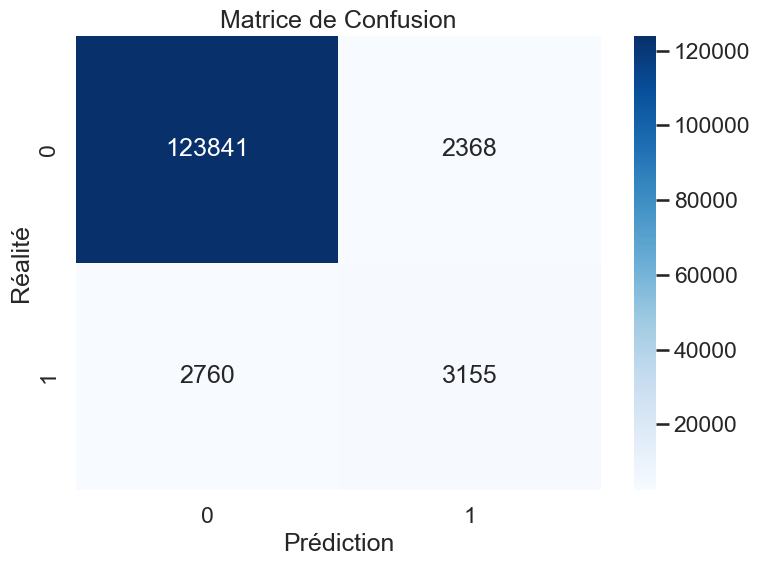

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion')
plt.tight_layout()
plt.show()